In [55]:
import pandas as pd
import numpy as np

import os
import re
import sys
import json
from typing import List
from datetime import datetime

import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.tokenize.api import TokenizerI
from nltk.stem import StemmerI, WordNetLemmatizer
import contractions

import torch
import torch.nn.utils.rnn as rnn_utils
from torch.utils.data import Dataset, DataLoader, RandomSampler

from matplotlib.figure import Figure
import seaborn as sns

# sklearn imports
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import confusion_matrix, classification_report, f1_score, roc_curve, RocCurveDisplay, precision_score, recall_score

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import warnings
warnings.filterwarnings('ignore')

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Clement\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Clement\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Clement\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [56]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [57]:
import csv

#dt = pd.read_csv("training.1600000.processed.noemoticon.csv", encoding='latin-1', delimiter=",", header=None)
#dt.columns = ['sentiment','id','date','flag','user','tweet']

dt = pd.read_csv("training.1600000.mixed.csv", encoding='latin-1', delimiter=",", nrows= 100000)

In [58]:
#randomDT = shuffle(dt)
#print(randomDT.columns)
#randomDT.drop(randomDT.columns[[0]], axis=1, inplace=True)

In [59]:
#randomDT.to_csv("training.1600000.mixed.csv")

In [60]:
dt.sentiment = dt.sentiment.map({4:1,0:0})

452 duplicate rows dropped!
Current row count: 99548




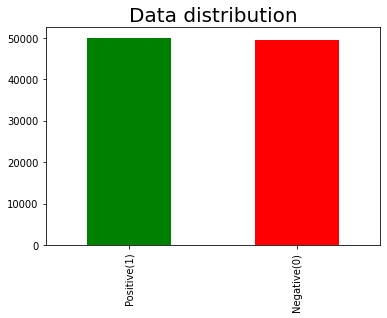

In [61]:
# Remove duplicate tweets
init_count = len(dt)
tweet_unique = dt.tweet.drop_duplicates(keep=False)
records_with_same_tweet = dt[True ^ dt.tweet.isin(tweet_unique)]
records_with_same_tweet[['sentiment', 'user', 'tweet']]
dt = dt[True ^ dt.tweet.isin(records_with_same_tweet.tweet)]
curr_count = len(dt)
print(f"{init_count - curr_count} duplicate rows dropped!\nCurrent row count: {curr_count}\n\n")

dt.sentiment.map({1:"Positive(1)",0:"Negative(0)"}).value_counts().plot(kind='bar', color=['green', 'red'])
plt.title("Data distribution", fontdict={"fontsize": 20})
plt.show()

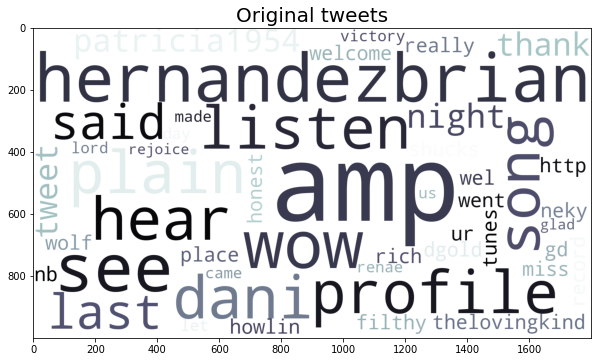

In [62]:
stop_words = set(stopwords.words("english"))

def word_count(df, title):
    word_cloud = WordCloud(max_words=200,
                           background_color='white',
                           stopwords=stop_words,
                           colormap='bone',
                           height=1000,
                           width=1800)
    tweets = df.tweet.values
    word_cloud.generate(str(tweets).lower())
    fig = plt.figure()
    plt.imshow(word_cloud)
    fig.set_figwidth(10)
    fig.set_figheight(10)
    plt.title(title, fontdict={"fontsize": 20})
    plt.show()

word_count(dt, "Original tweets")

In [63]:
# use the lowercase
dt["tweet"] = dt["tweet"].str.lower()

# abbreviation check list
abbreviations = {
        "$" : " dollar ",
        "€" : " euro ",
        "4ao" : "for adults only",
        "a.m" : "before midday",
        "a3" : "anytime anywhere anyplace",
        "aamof" : "as a matter of fact",
        "acct" : "account",
        "adih" : "another day in hell",
        "afaic" : "as far as i am concerned",
        "afaict" : "as far as i can tell",
        "afaik" : "as far as i know",
        "afair" : "as far as i remember",
        "afk" : "away from keyboard",
        "app" : "application",
        "approx" : "approximately",
        "apps" : "applications",
        "asap" : "as soon as possible",
        "asl" : "age, sex, location",
        "atk" : "at the keyboard",
        "ave." : "avenue",
        "aymm" : "are you my mother",
        "ayor" : "at your own risk",
        "b&b" : "bed and breakfast",
        "b+b" : "bed and breakfast",
        "b.c" : "before christ",
        "b2b" : "business to business",
        "b2c" : "business to customer",
        "b4" : "before",
        "b4n" : "bye for now",
        "b@u" : "back at you",
        "bae" : "before anyone else",
        "bak" : "back at keyboard",
        "bbbg" : "bye bye be good",
        "bbc" : "british broadcasting corporation",
        "bbias" : "be back in a second",
        "bbl" : "be back later",
        "bbs" : "be back soon",
        "be4" : "before",
        "bfn" : "bye for now",
        "blvd" : "boulevard",
        "bout" : "about",
        "brb" : "be right back",
        "bros" : "brothers",
        "brt" : "be right there",
        "bsaaw" : "big smile and a wink",
        "btw" : "by the way",
        "bwl" : "bursting with laughter",
        "c/o" : "care of",
        "cet" : "central european time",
        "cf" : "compare",
        "cia" : "central intelligence agency",
        "csl" : "can not stop laughing",
        "cu" : "see you",
        "cul8r" : "see you later",
        "cv" : "curriculum vitae",
        "cwot" : "complete waste of time",
        "cya" : "see you",
        "cyt" : "see you tomorrow",
        "dae" : "does anyone else",
        "dbmib" : "do not bother me i am busy",
        "diy" : "do it yourself",
        "dm" : "direct message",
        "dwh" : "during work hours",
        "e123" : "easy as one two three",
        "eet" : "eastern european time",
        "eg" : "example",
        "embm" : "early morning business meeting",
        "encl" : "enclosed",
        "encl." : "enclosed",
        "etc" : "and so on",
        "faq" : "frequently asked questions",
        "fawc" : "for anyone who cares",
        "fb" : "facebook",
        "fc" : "fingers crossed",
        "fig" : "figure",
        "fimh" : "forever in my heart",
        "ft." : "feet",
        "ft" : "featuring",
        "ftl" : "for the loss",
        "ftw" : "for the win",
        "fwiw" : "for what it is worth",
        "fyi" : "for your information",
        "g9" : "genius",
        "gahoy" : "get a hold of yourself",
        "gal" : "get a life",
        "gcse" : "general certificate of secondary education",
        "gfn" : "gone for now",
        "gg" : "good game",
        "gl" : "good luck",
        "glhf" : "good luck have fun",
        "gmt" : "greenwich mean time",
        "gmta" : "great minds think alike",
        "gn" : "good night",
        "g.o.a.t" : "greatest of all time",
        "goat" : "greatest of all time",
        "goi" : "get over it",
        "gps" : "global positioning system",
        "gr8" : "great",
        "gratz" : "congratulations",
        "gyal" : "girl",
        "h&c" : "hot and cold",
        "hp" : "horsepower",
        "hr" : "hour",
        "hrh" : "his royal highness",
        "ht" : "height",
        "ibrb" : "i will be right back",
        "ic" : "i see",
        "icq" : "i seek you",
        "icymi" : "in case you missed it",
        "idc" : "i do not care",
        "idgadt" : "i do not give a damn fuck",
        "idgaf" : "i do not give a fuck",
        "idk" : "i do not know",
        "ie" : "that is",
        "i.e" : "that is",
        "ifyp" : "i feel your pain",
        "ig" : "instagram",
        "iirc" : "if i remember correctly",
        "ilu" : "i love you",
        "ily" : "i love you",
        "imho" : "in my humble opinion",
        "imo" : "in my opinion",
        "imu" : "i miss you",
        "iow" : "in other words",
        "irl" : "in real life",
        "j4f" : "just for fun",
        "jic" : "just in case",
        "jk" : "just kidding",
        "jsyk" : "just so you know",
        "l8r" : "later",
        "lb" : "pound",
        "lbs" : "pounds",
        "ldr" : "long distance relationship",
        "lmao" : "laugh my ass off",
        "lmfao" : "laugh my fucking ass off",
        "lol" : "laughing out loud",
        "ltd" : "limited",
        "ltns" : "long time no see",
        "m8" : "mate",
        "mf" : "motherfucker",
        "mfs" : "motherfuckers",
        "mfw" : "my face when",
        "mofo" : "motherfucker",
        "mph" : "miles per hour",
        "mr" : "mister",
        "mrw" : "my reaction when",
        "ms" : "miss",
        "mte" : "my thoughts exactly",
        "nagi" : "not a good idea",
        "nbc" : "national broadcasting company",
        "nbd" : "not big deal",
        "nfs" : "not for sale",
        "ngl" : "not going to lie",
        "nhs" : "national health service",
        "nrn" : "no reply necessary",
        "nsfl" : "not safe for life",
        "nsfw" : "not safe for work",
        "nth" : "nice to have",
        "nvr" : "never",
        "nyc" : "new york city",
        "oc" : "original content",
        "og" : "original",
        "ohp" : "overhead projector",
        "oic" : "oh i see",
        "omdb" : "over my dead body",
        "omg" : "oh my god",
        "omw" : "on my way",
        "p.a" : "per annum",
        "p.m" : "after midday",
        "pm" : "prime minister",
        "poc" : "people of color",
        "pov" : "point of view",
        "pp" : "pages",
        "ppl" : "people",
        "prw" : "parents are watching",
        "ps" : "postscript",
        "pt" : "point",
        "ptb" : "please text back",
        "pto" : "please turn over",
        "qpsa" : "what happens",
        "ratchet" : "rude",
        "rbtl" : "read between the lines",
        "rlrt" : "real life retweet",
        "rofl" : "rolling on the floor laughing",
        "roflol" : "rolling on the floor laughing out loud",
        "rotflmao" : "rolling on the floor laughing my ass off",
        "rt" : "retweet",
        "ruok" : "are you ok",
        "sfw" : "safe for work",
        "sk8" : "skate",
        "smh" : "shake my head",
        "sq" : "square",
        "srsly" : "seriously",
        "ssdd" : "same stuff different day",
        "tbh" : "to be honest",
        "tbs" : "tablespooful",
        "tbsp" : "tablespooful",
        "tfw" : "that feeling when",
        "thks" : "thank you",
        "tho" : "though",
        "thx" : "thank you",
        "tia" : "thanks in advance",
        "til" : "today i learned",
        "tl;dr" : "too long i did not read",
        "tldr" : "too long i did not read",
        "tmb" : "tweet me back",
        "tntl" : "trying not to laugh",
        "ttyl" : "talk to you later",
        "u" : "you",
        "u2" : "you too",
        "u4e" : "yours for ever",
        "utc" : "coordinated universal time",
        "w/" : "with",
        "w/o" : "without",
        "w8" : "wait",
        "wassup" : "what is up",
        "wb" : "welcome back",
        "wtf" : "what the fuck",
        "wtg" : "way to go",
        "wtpa" : "where the party at",
        "wuf" : "where are you from",
        "wuzup" : "what is up",
        "wywh" : "wish you were here",
        "yd" : "yard",
        "ygtr" : "you got that right",
        "ynk" : "you never know",
        "zzz" : "sleeping bored and tired"
    }

In [64]:
def decontract(text):
    # remove special chars
    text = re.sub(r"\x89Û_", "", text)
    text = re.sub(r"\x89ÛÒ", "", text)
    text = re.sub(r"\x89ÛÓ", "", text)
    text = re.sub(r"\x89ÛÏ", "", text)
    text = re.sub(r"\x89Û÷", "", text)
    text = re.sub(r"\x89Ûª", "", text)
    text = re.sub(r"\x89Û\x9d", "", text)
    text = re.sub(r"å_", "", text)
    text = re.sub(r"\x89Û¢", "", text)
    text = re.sub(r"\x89Û¢åÊ", "", text)
    text = re.sub(r"åÊ", "", text)
    text = re.sub(r"åÈ", "", text)
    text = re.sub(r"Ì©", "e", text)
    text = re.sub(r"å¨", "", text)
    text = re.sub(r"åÇ", "", text)
    text = re.sub(r"åÀ", "", text)
    # remove contractions
    text = re.sub(r"let\x89Ûªs", "let us", text)
    text = re.sub(r"let's", "let us", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"there's", "there is", text)
    text = re.sub(r"we're", "we are", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"that\x89Ûªs", "that is", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"wont", "will not", text)
    text = re.sub(r"they're", "they are", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"cant", "cannot", text)
    text = re.sub(r"can\x89Ûªt", "cannot", text)
    text = re.sub(r"wasn't", "was not", text)
    text = re.sub(r"wasnt", "was not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"dont", "do not", text)
    text = re.sub(r"donå«t", "do not", text)
    text = re.sub(r"don\x89Ûªt", "do not", text)
    text = re.sub(r"didn't", "did not", text)
    text = re.sub(r"didnt", "did not", text)
    text = re.sub(r"aren't", "are not", text)
    text = re.sub(r"isn't", "is not", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"haven't", "have not", text)
    text = re.sub(r"hasn't", "has not", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"it\x89Ûªs", "it is", text)
    text = re.sub(r"you're", "you are", text)
    text = re.sub(r"you\x89Ûªre", "you are", text)
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"i\x89Ûªm", "i am", text)
    text = re.sub(r"shoulda", "should have", text)
    text = re.sub(r"shouldn't", "should not", text)
    text = re.sub(r"wouldn't", "would not", text)
    text = re.sub(r"wouldn\x89Ûªt", "would not", text)
    text = re.sub(r"here's", "here is", text)
    text = re.sub(r"here\x89Ûªs", "here is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"you've", "you have", text)
    text = re.sub(r"you\x89Ûªve", "you have", text)
    text = re.sub(r"youve", "you have", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"we've", "we have", text)
    text = re.sub(r"doesn't", "does not", text)
    text = re.sub(r"doesn\x89Ûªt", "does not", text)
    text = re.sub(r"who's", "who is", text)
    text = re.sub(r"i've", "i have", text)
    text = re.sub(r"i\x89Ûªve", "i have", text)
    text = re.sub(r"y'all", "you all", text)
    text = re.sub(r"would've", "would have", text)
    text = re.sub(r"it'll", "it will", text)
    text = re.sub(r"we'll", "we will", text)
    text = re.sub(r"he'll", "he will", text)
    text = re.sub(r"weren't", "were not", text)
    text = re.sub(r"didn't", "did not", text)
    text = re.sub(r"they'll", "they will", text)
    text = re.sub(r"they'd", "they would", text)
    text = re.sub(r"they've", "they have", text)
    text = re.sub(r"i'd", "i would", text)
    text = re.sub(r"I\x89Ûªd", "I would", text)
    text = re.sub(r"should've", "should have", text)
    text = re.sub(r"we'd", "we would", text)
    text = re.sub(r"i'll", "i will", text)
    text = re.sub(r"^ill$", "i will", text)
    text = re.sub(r"you'll", "you will", text)
    text = re.sub(r"you\x89Ûªll", "you will", text)
    text = re.sub(r"ain't", "am not", text)
    text = re.sub(r"you'd", "you would", text)
    text = re.sub(r"could've", "could have", text)
    text = re.sub(r"mÌ¼sica", "music", text)
    text = re.sub(r"some1", "someone", text)
    text = re.sub(r"yrs", "years", text)
    text = re.sub(r"hrs", "hours", text)
    text = re.sub(r"2morow|2moro", "tomorrow", text)
    text = re.sub(r"2day", "today", text)
    text = re.sub(r"4got|4gotten", "forget", text)
    text = re.sub(r"b-day|bday", "b-day", text)
    text = re.sub(r"mother's", "mother", text)
    text = re.sub(r"mom's", "mom", text)
    text = re.sub(r"dad's", "dad", text)
    text = re.sub(r"^[h|a]+$", "haha", text)
    text = re.sub(r"lmao|lolz|rofl", "lol", text)
    text = re.sub(r"thanx|thnx|thx", "thanks", text)
    text = re.sub(r'all[l]+', "all", text)
    text = re.sub(r'so[o]+', "so", text)
    text = re.sub(r'a[w]+', "awww", text)
    text = re.sub(r'why[y]+', "why", text)
    text = re.sub(r'way[y]+', "way", text)
    text = re.sub(r'will[l]+', "will", text)
    text = re.sub(r'oo[o]+h', "ooh", text)
    text = re.sub(r'hey[y]+', "hey", text)
    text = re.sub(r"boo[o]+m", "boom", text)
    text = re.sub(r"co[o]+ld", "cold", text)
    text = re.sub(r"goo[o]+d", "good", text)
    text = re.sub(r"luckigrrl", "lucky girl", text)
    text = re.sub(r"evolvin", "evolving", text)

    # specific
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"@", "" , text)         # removal of @
    text = re.sub(r"http\S+", "", text)   # removal of URLs
    text = re.sub(r"#", "", text)          # hashtag processing

    # general
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)

    # deal with some abbreviations
    words = text.split()
    text = ' '.join([abbreviations[word] if word in abbreviations.keys() else word.strip(string.punctuation) for word in words])

    # character entity references
    text = re.sub(r"&gt;", ">", text)
    text = re.sub(r"&lt;", "<", text)
    text = re.sub(r"&amp;", "&", text)

    # typos, slang and informal abbreviations
    text = re.sub(r"w/e", "whatever", text)
    text = re.sub(r"usagov", "usa government", text)
    text = re.sub(r"<3", "love", text)
    text = re.sub(r"trfc", "traffic", text)
    # remove urls
    # text = re.sub(r"http\S+", "", text)

    # remove mentions
    text = re.sub(r'^@[0-9a-zA-Z_]+', "", text)

    # words with punctuations and special characters
    for punc in string.punctuation:
        text = text.replace(punc, '')

    # ... and ..
    text = text.replace('...', ' ... ')
    if '...' not in text:
        text = text.replace('..', ' ... ')

    return text

def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stop_words])

def remove_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1', text)

def remove_email(text):
    return re.sub('@[^\s]+', ' ', text)

def remove_URLs(text):
    return re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',text)

def remove_numbers(text):
    return re.sub('[0-9]+', '', text)

def clean_tweets(text):
    text = decontract(text)
    text = remove_stopwords(text)
    #text = remove_repeating_char(text)
    text = remove_email(text)
    text = remove_URLs(text)
    #text = remove_numbers(text)
    return text

In [65]:
init_rowcount = len(dt)
dt['tokens'] = dt.tweet.apply(lambda tweet: clean_tweets(tweet))
dt['length'] = dt.tokens.str.len()
dt = dt[dt.length != 0]
curr_rowcount = len(dt)
avg_tweet_length = dt.length.mode().iat[0]
min_tweet_length = dt.length.min()
print(f"functions applied!\n\n{init_rowcount - curr_rowcount} rows with zero-length tweets dropped!\nMin tweet length observed: {min_tweet_length} words\nAvg tweet length observed: {avg_tweet_length} words")
dt.head()

functions applied!

36 rows with zero-length tweets dropped!
Min tweet length observed: 1 words
Avg tweet length observed: 30 words


Unnamed: 0  sentiment          id                          date      flag  \
0     1424724          1  2058914950  Sat Jun 06 15:52:53 PDT 2009  NO_QUERY   
1     1352850          1  2046591147  Fri Jun 05 12:24:18 PDT 2009  NO_QUERY   
2      805971          1  1468742319  Tue Apr 07 03:29:15 PDT 2009  NO_QUERY   
3     1375588          1  2051611565  Fri Jun 05 22:24:19 PDT 2009  NO_QUERY   
4     1122312          1  1974315684  Sat May 30 12:52:46 PDT 2009  NO_QUERY   

            user                                              tweet  \
0  jacquegormley  @hernandezbrian wow, i see how your profile is...   
1    solutionbox             @patricia1954 thank you for the tweet    
2        GayBenz  @thelovingkind ur welcome  . nb i really is mi...   
3   woahitsamani  @sicknastyashy good luckkkkkkkk &lt;3333333333...   
4      mike90210  @philipwagnerla happy birthday, man! god bless...   

                                              tokens  length  
0  hernandezbrian wow see profile plain song list...      74  
1                           patricia1954 thank tweet      24  
2  thelovingkind ur welcome nb really miss 1 plac...      59  
3  sicknastyashy good luckkkkkkkk lt33333333333 t...      66  
4  philipwagnerla happy birthday man god bless gr...      60

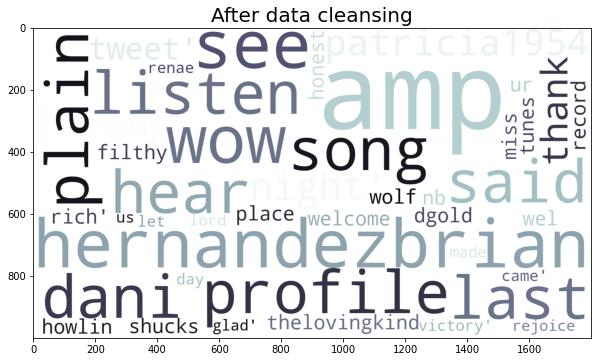

In [66]:
dt = dt[['sentiment', 'tokens']]
dt.rename(columns={'tokens': 'tweet'}, inplace=True)
#dt = pd.concat([dt[dt.sentiment == 0][:200000], dt[dt.sentiment == 1][:200000]])
dt.to_csv("./noemoticon-cleaned.csv")

word_count(dt, "After data cleansing")

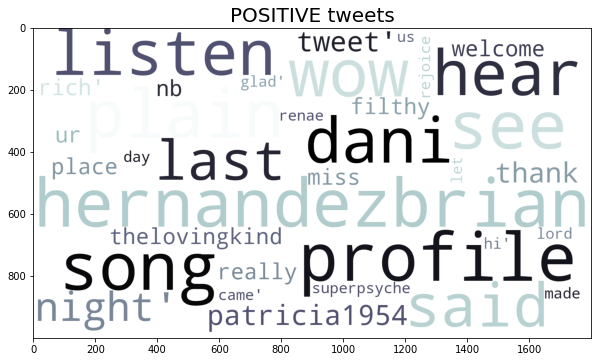

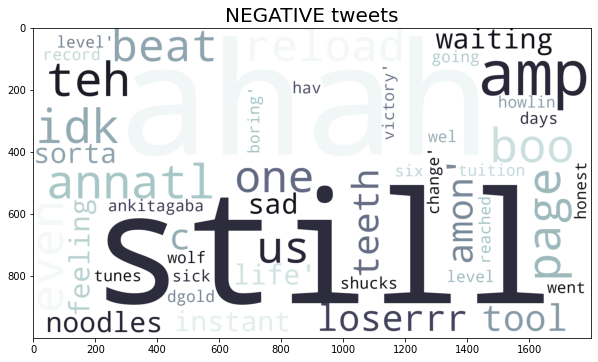

In [67]:
word_count(dt[dt.sentiment == 1], "POSITIVE tweets")
print("")
word_count(dt[dt.sentiment == 0], "NEGATIVE tweets")

In [68]:
tweet_source = pd.read_csv("./noemoticon-cleaned.csv")
print(f"{len(tweet_source)} rows loaded to memory!\nColumns: {tweet_source.columns}\n")
tweet_source.reset_index()
tweet_source = tweet_source.sample(frac=1.)
print(f"{len(tweet_source)} rows sampled!\nColumns: {tweet_source.columns}")

99512 rows loaded to memory!
Columns: Index(['Unnamed: 0', 'sentiment', 'tweet'], dtype='object')

99512 rows sampled!
Columns: Index(['Unnamed: 0', 'sentiment', 'tweet'], dtype='object')


In [69]:
from wordcloud import STOPWORDS
import timeit

# Setup compiled regular expressions for tokenization
NON_ALNUM_RE = re.compile(r'[^a-zA-Z0-9]')
USER_RE = re.compile('@[^\s]+')
HTTP_URL_RE = re.compile("((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)")
SPACES_RE = re.compile('[\s]+')

# Setup tokenizer and lemmatizer
wn_lemmatizer = WordNetLemmatizer()
tw_tokenizer = TweetTokenizer(preserve_case=False, reduce_len=True)

#@timeit
def make_ngrams(words: List[str], n: int = 1, log_time: dict = None, log_name: str = None) -> List[str]:
    if n == 1 or not words or n > len(words):
        return words
    # Otherwise we process n-gram windows and proceed
    n_grams = []
    for i in range(len(words) - n + 1):
        n_grams.append('_'.join(words[i:i+n]))
    return n_grams

#@timeit
def stem_and_tokenize(origin_text: str, lemmatizer: WordNetLemmatizer, tokenizer: TokenizerI, n_grams: int = 1, log_time=None) -> List[str]:
    text = origin_text.lower()
    # Replace the URLs and usernames
    text = HTTP_URL_RE.sub(' url', text)
    text = USER_RE.sub(' user', text)
    # Expand contractions before additional processing
    text = contractions.fix(text)
    # Replace non alpha numeric characters with empty string
    text = NON_ALNUM_RE.sub(' ', text)
    text = SPACES_RE.sub(' ', text)
    # Tokenize the processed text and make n-grams
    tokens = tokenizer.tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in STOPWORDS]
    return make_ngrams(tokens, n_grams, log_time=log_time)

def make_tokens(row_data: str, n_grams: int = 1, log_times=None) -> List[str]:
    return stem_and_tokenize(row_data, wn_lemmatizer, tw_tokenizer, n_grams=n_grams,log_time=log_times)

In [70]:
# We will use a local reference to the len function as a small optimization
local_len = len

df_processed = tweet_source.copy()
df_processed['tokens'] = df_processed['tweet'].apply(make_tokens)
df_processed['text_length'] = df_processed['tweet'].apply(local_len)

In [71]:
n_gram_options = {
    'unigrams': 1,
    'bigrams': 2,
    'trigrams': 3,
}

for n_gram, n in n_gram_options.items():
    df_processed[n_gram] = df_processed['tokens'].apply(lambda x: ' '.join(make_ngrams(x, n, log_time=None, log_name=f"{n_gram}_stem")))
    # Add string length, token:text ratio for unigrams only
    if n == 1:
        df_processed[f"{n_gram}_length"] = df_processed[n_gram].apply(len)
        df_processed['unigram_to_text'] = df_processed[f"{n_gram}_length"] / df_processed['text_length']

df_processed.head()

Unnamed: 0  sentiment  \
27289       27412          0   
6902         6936          0   
29135       29266          0   
23034       23134          0   
53751       54006          0   

                                                   tweet  \
27289                                     lance broadway   
6902                 stacey79 irishmel21 sad aussie fans   
29135  theclimbergirl fun pics ya lovely rabid love b...   
23034  alsotop yeah look pretty ewwie taste omnomlici...   
53751                                        go home ill   

                                                  tokens  text_length  \
27289                                  [lance, broadway]           14   
6902        [stacey, 79, irishmel, 21, sad, aussie, fan]           35   
29135  [theclimbergirl, fun, pic, ya, lovely, rabid, ...           57   
23034  [alsotop, yeah, look, pretty, ewwie, taste, om...           60   
53751                                    [go, home, ill]           11   

                                                unigrams  unigrams_length  \
27289                                     lance broadway               14   
6902                stacey 79 irishmel 21 sad aussie fan               36   
29135  theclimbergirl fun pic ya lovely rabid love bu...               54   
23034  alsotop yeah look pretty ewwie taste omnomlici...               59   
53751                                        go home ill               11   

       unigram_to_text                                            bigrams  \
27289         1.000000                                     lance_broadway   
6902          1.028571  stacey_79 79_irishmel irishmel_21 21_sad sad_a...   
29135         0.947368  theclimbergirl_fun fun_pic pic_ya ya_lovely lo...   
23034         0.983333  alsotop_yeah yeah_look look_pretty pretty_ewwi...   
53751         1.000000                                   go_home home_ill   

                                                trigrams  
27289                                     lance broadway  
6902   stacey_79_irishmel 79_irishmel_21 irishmel_21_...  
29135  theclimbergirl_fun_pic fun_pic_ya pic_ya_lovel...  
23034  alsotop_yeah_look yeah_look_pretty look_pretty...  
53751                                        go_home_ill

In [72]:
from collections import Counter
from typing import Tuple, List, Dict

class FrequencyCollection:
    def __init__(self, all_counts: Dict[str, int], pos: Dict[str, int], neg: Dict[str, int]):
        self.all_counts = all_counts
        self.pos = pos
        self.neg = neg


def create_frequency_counts(feature_col: str) -> FrequencyCollection:
    all_counts = Counter()
    pos_counts = Counter()
    neg_counts = Counter()

    def count_tokens_from_list(sentiment: int, tokens: List[str]):
        if sentiment == 0:
            neg_counts.update(tokens)
        else:
            pos_counts.update(tokens)
        all_counts.update(tokens)

    if feature_col == 'tokens':
        df_processed.loc[df_processed['sentiment'] == 0, feature_col].apply(lambda x: count_tokens_from_list(0, x))
        print("Finished counting negative tokens")
        df_processed.loc[df_processed['sentiment'] != 0, feature_col].apply(lambda x: count_tokens_from_list(1, x))
        print("Finished counting positive tokens")
    else:
        df_processed.loc[df_processed['sentiment'] == 0, feature_col].apply(lambda x: count_tokens_from_list(0, x.split(' ')))
        print(f"Finished counting negative {feature_col.title()}")
        df_processed.loc[df_processed['sentiment'] != 0, feature_col].apply(lambda x: count_tokens_from_list(1, x.split(' ')))
        print(f"Finished counting positive {feature_col.title()}")

    return FrequencyCollection(all_counts, pos_counts, neg_counts)


def word_cloud_from_dict(title: str, sub_title: str,
                         word_counts: Dict[str, int],
                         fig: Figure, subplot: Tuple[int, int, int],
                         max_words: int = 100,
                         bg_color: str = 'white'):

    # Create the word cloud image
    wc = WordCloud(max_words=max_words, width=1600, height=800,
                   collocations=False,
                   background_color=bg_color)
    wc.generate_from_frequencies(word_counts)

    # Add to the provided figure and subplot
    fig.add_subplot(*subplot)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis('off')
    plt.title(f"{title.title()}\n{sub_title.title()} Sentiment", fontdict={'fontsize': 20})


def make_frequency_clouds(fig: Figure, pos_counts: Dict[str, int], neg_counts: Dict[str, int], feature_col: str, rows: int, cols: int, idx: int, max_words: int = 100):

    # Observation tells us that these words don't contribute much to the informative value of the figures
    word_cloud_from_dict(feature_col, "Negative", neg_counts, fig, (rows, cols, (2 * idx + 1)), bg_color='red')
    word_cloud_from_dict(feature_col, "Positive", pos_counts, fig, (rows, cols, (2 * idx + 2)), bg_color='whitesmoke')

In [73]:
token_counts = create_frequency_counts('tokens')
bigrams_counts= create_frequency_counts('bigrams')
trigrams_counts = create_frequency_counts('trigrams')

frequency_counts= [token_counts, bigrams_counts, trigrams_counts]

Finished counting negative tokens
Finished counting positive tokens
Finished counting negative Bigrams
Finished counting positive Bigrams
Finished counting negative Trigrams
Finished counting positive Trigrams


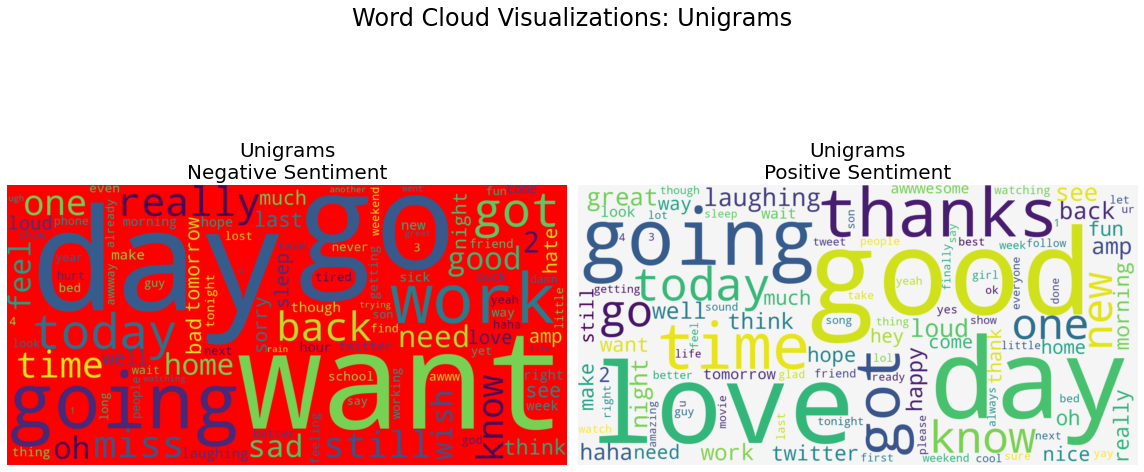

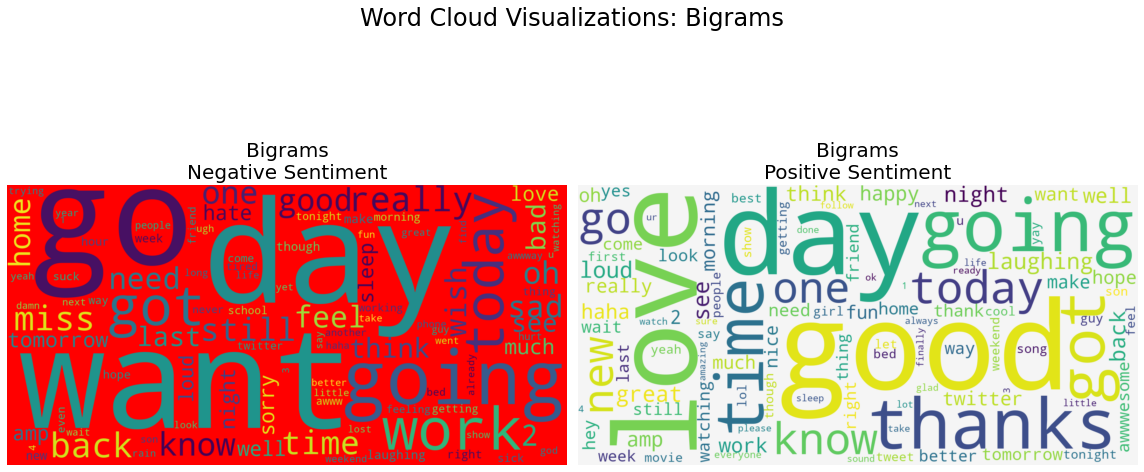

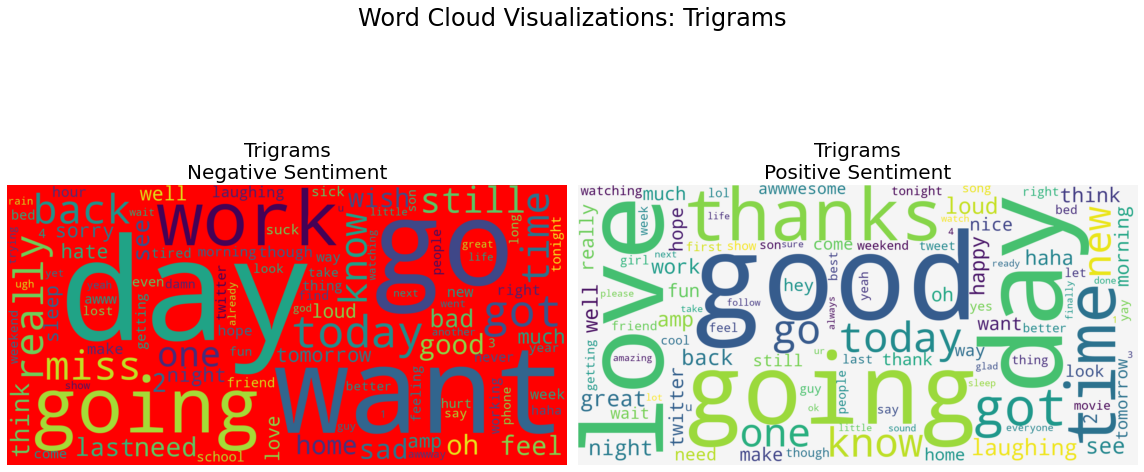

In [74]:
for feature_col in n_gram_options.keys():
    fig = plt.figure(figsize=(16, 16))
    rows, cols = 2, 2

    make_frequency_clouds(fig, token_counts.pos, token_counts.neg, feature_col, rows, cols, 0)

    fig.suptitle(f"Word Cloud Visualizations: {feature_col.title()}", fontsize=24)
    fig.tight_layout()
plt.show()
plt.close()

In [75]:
def top_count_histogram(token_counts: FrequencyCollection,
                        feature_col: str,
                        n_most_common: int,
                        figsize: Tuple[int, int] = (16, 16)):

    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=figsize)

    # Plot histogram of the top 25 most common words for positive sentiment
    pos_token_df = pd.DataFrame(token_counts.pos.most_common(n_most_common), columns=['token', 'count'])
    pos_token_df[pos_token_df['token'] != ''].plot(x='token', y='count', kind='bar', title="Positive Token Counts", ax=axes[0])
    # Plot histogram of the top 25 most common words for negative sentiment
    neg_token_df = pd.DataFrame(token_counts.neg.most_common(n_most_common), columns=['token', 'count'])
    neg_token_df[neg_token_df['token'] != ''].plot(x='token', y='count', kind='bar', title="Negative Token Counts", ax=axes[1])
    for ax in axes:
        ax.title.set_size(20)
    fig.tight_layout(pad=10.0)
    fig.suptitle(f"Frequency Histogram: {feature_col.title()}", fontsize=24)
    plt.show()
    plt.close()

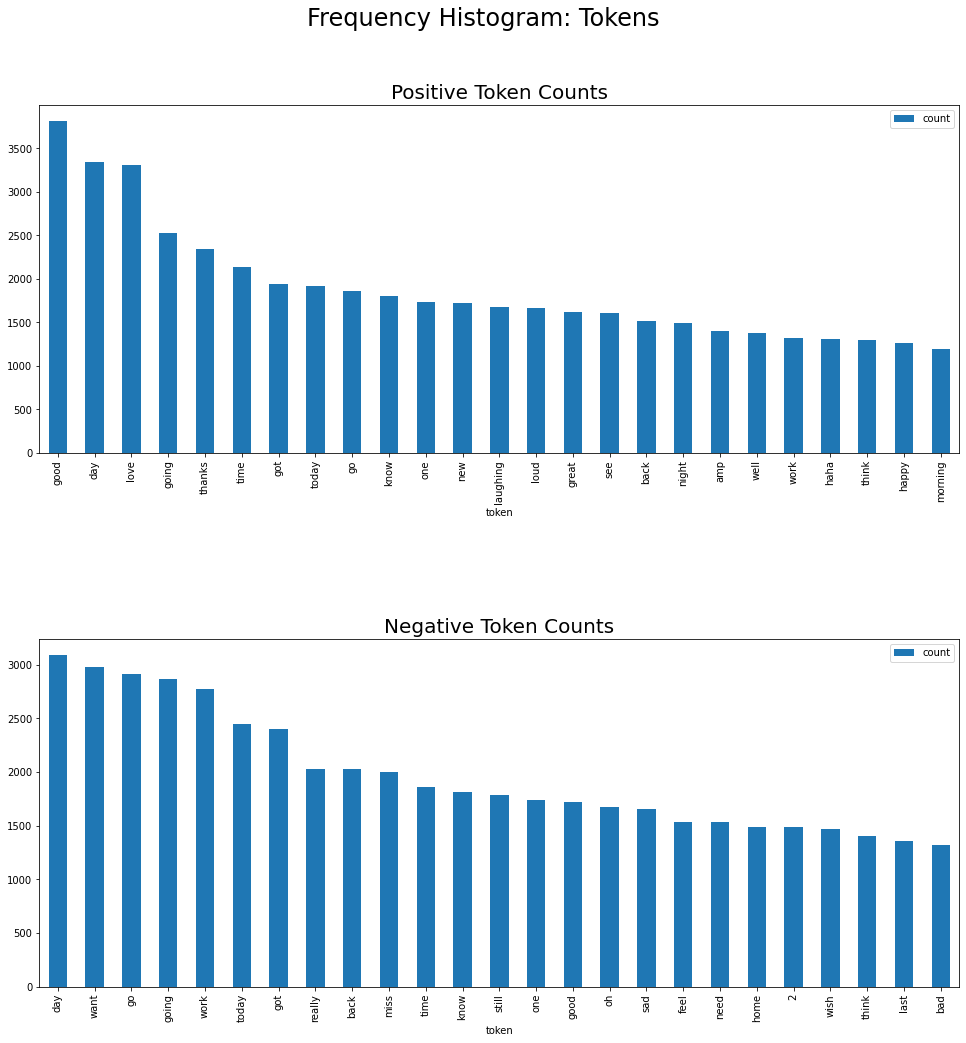

In [76]:
top_count_histogram(token_counts, 'tokens', 25)

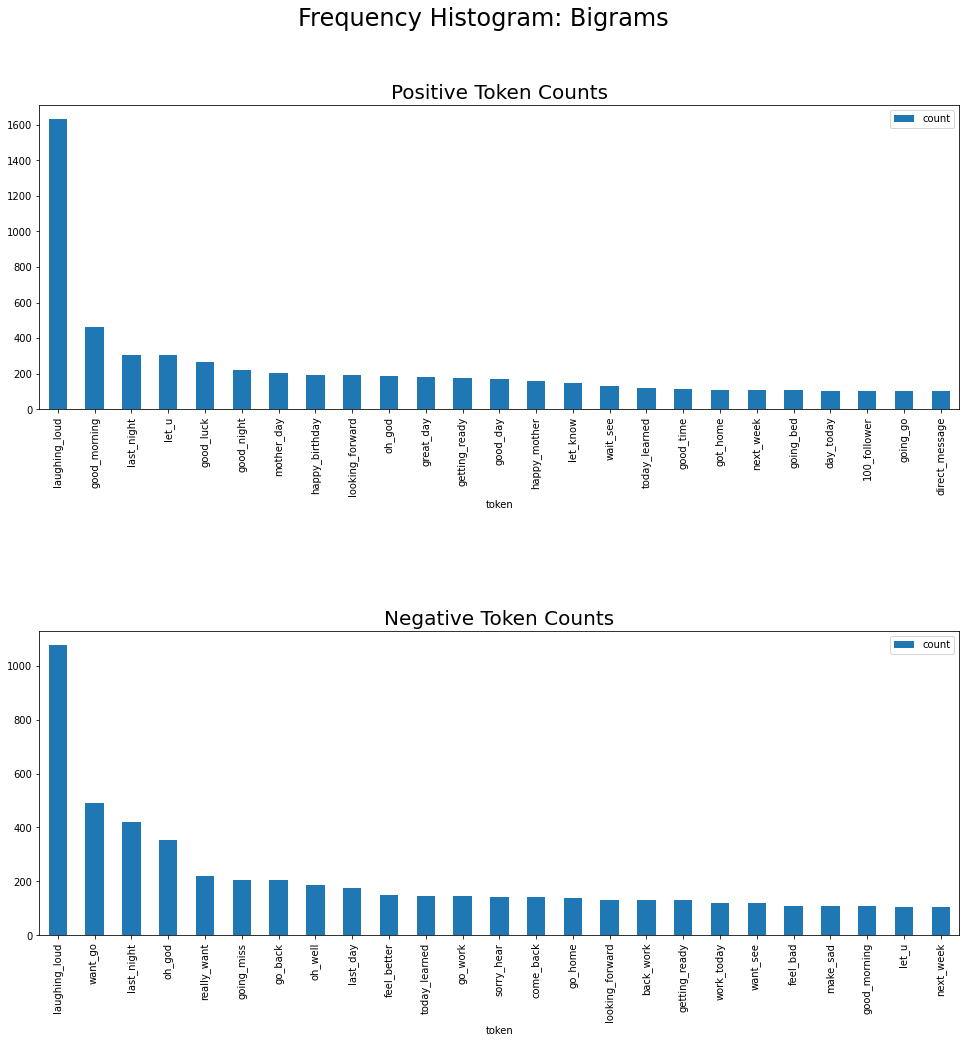

In [77]:
top_count_histogram(bigrams_counts, 'bigrams', 25)

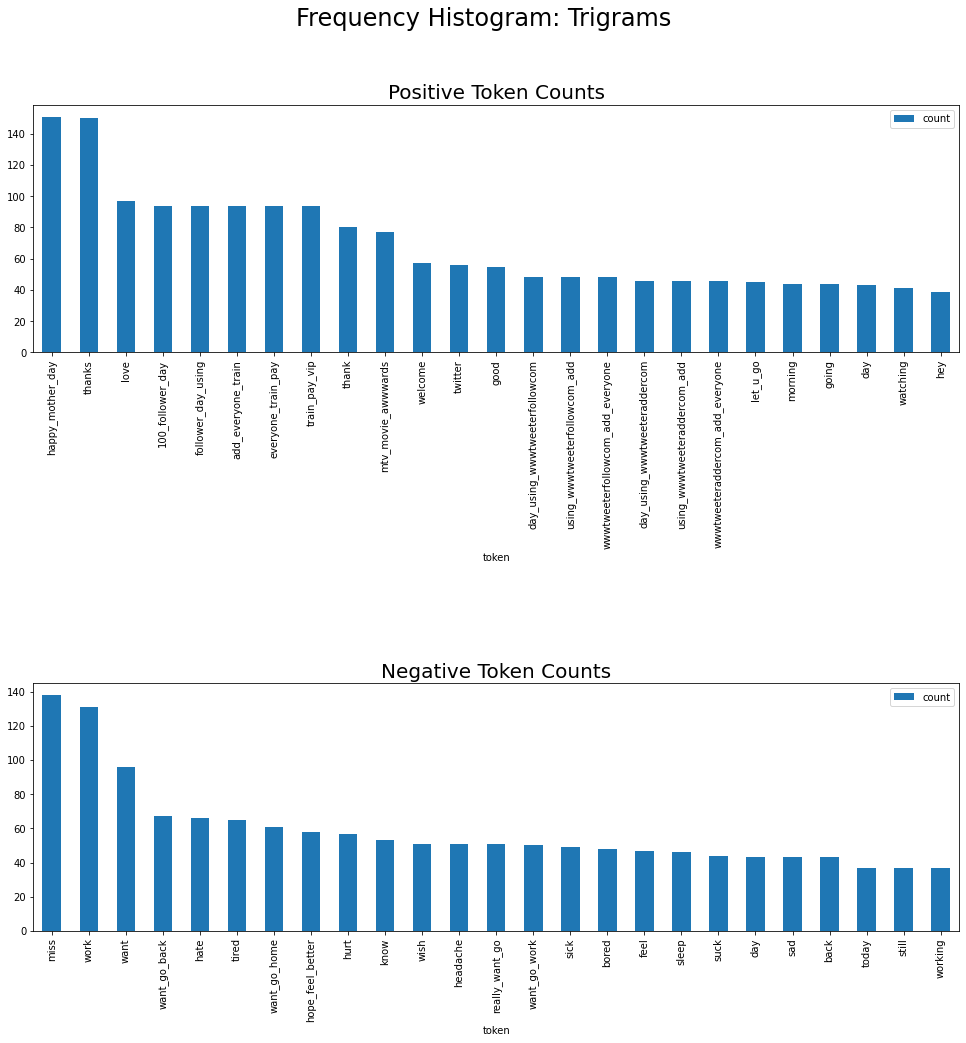

In [78]:
top_count_histogram(trigrams_counts, 'trigrams', 25)

In [1]:
columns_to_drop = ['tweet', 'unigram_to_text', 'bigrams', 'trigrams']
df_processed.drop(columns_to_drop, axis=1, inplace=True)
df_processed.head()
train_set, test_set = train_test_split(df_processed, test_size=0.2, random_state=7)
print(f"Train Set:\nSize: {train_set.shape}\nTest Set:\nSize: {test_set.shape}")

NameError: name 'df_processed' is not defined

In [80]:
def samples_with_plot(origin_df: pd.DataFrame, sample_sizes=[1], make_plots: bool = False):
    rows = int(np.ceil(len(sample_sizes) / 2))
    fig, axes = plt.subplots(rows, 2, figsize=(16, rows * 4))
    sample_frames = []

    for ax, sample in zip(axes.ravel(), sample_sizes):
        sample_df = origin_df.sample(frac=sample, random_state=42).copy(deep=True)
        sample_frames.append(sample_df)
        sample_df.groupby('sentiment').count().plot(
            kind='bar',
            ax=ax,
            legend=False,
        )
        ax.set_xlabel(f"Sample Size: {sample * 100:.2f}%", fontsize=16)
        ax.set_ylabel("Example Count", fontsize=12)

    # Remove the unused axes from the figure before producing output
    fig.suptitle("Sentiment Polarity:\n0-Negative / 1-Positive", fontsize=20)
    plt.show()
    plt.close()
    return sample_frames

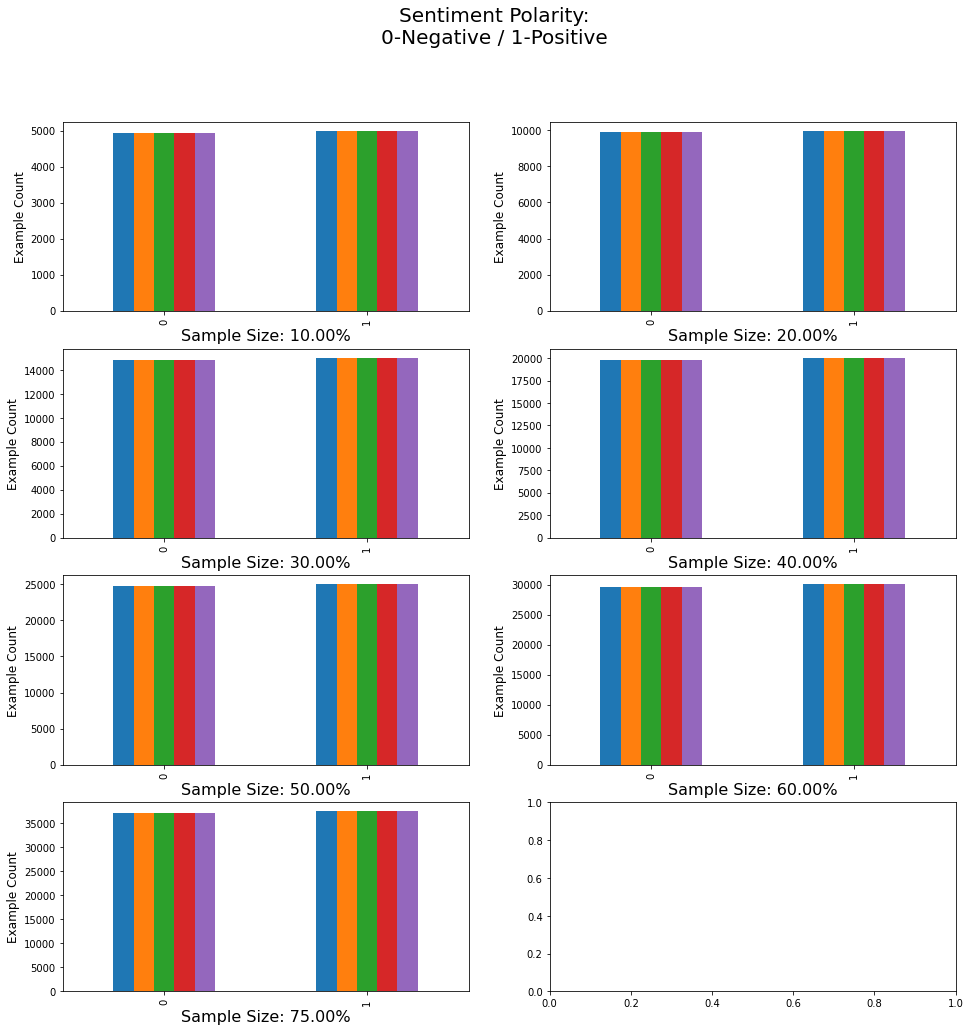

In [81]:
samplings = samples_with_plot(df_processed, sample_sizes=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.75], make_plots=True)
samplings.append(df_processed.sample(frac=1, random_state=42))

sample_frames = list(zip(["10", "20", "30", "50", "60", "75","100"], samplings))

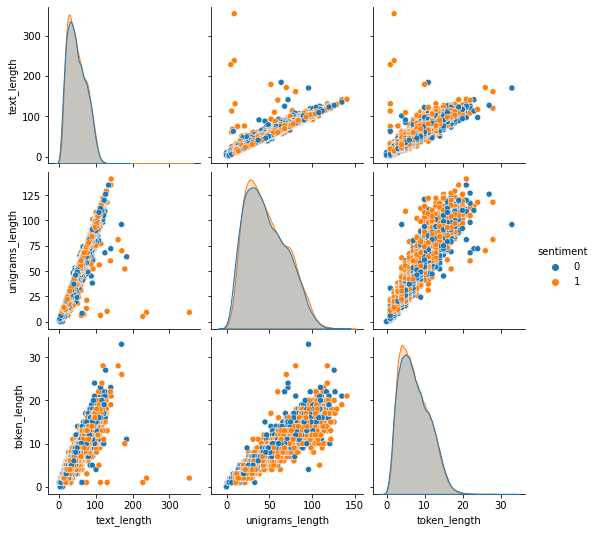

In [82]:
k_means_cols = ['sentiment', 'text_length', 'unigrams_length']

# Do text & token length show any relationship?

X_train = sample_frames[2][1][k_means_cols].copy()
X_train['token_length'] = sample_frames[2][1]['tokens'].apply(local_len)

sns.pairplot(X_train, hue='sentiment', diag_kind='kde')

In [83]:
# Splinter off the target from the training data
y_train = X_train['sentiment'].copy()
X_train.drop(['sentiment'], axis=1, inplace=True)

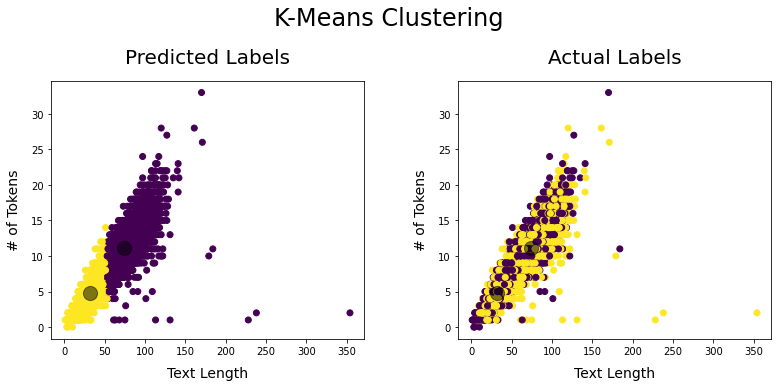

In [84]:
h = 0.02
C = 1.0

km_clf = KMeans(n_clusters=2, random_state=42)
km_clf.fit(X_train[['text_length', 'token_length']])

y_means = km_clf.predict(X_train[['text_length', 'token_length']])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.scatter(X_train['text_length'], X_train['token_length'], c=y_means)
centers = km_clf.cluster_centers_
ax1.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
ax1.set_xlabel("Text Length", fontdict={'size': 14}, labelpad=10)
ax1.set_ylabel("# of Tokens", fontdict={'size': 14}, labelpad=10)
ax1.set_title(f"Predicted Labels", fontdict={'size': 20}, pad=18)

ax2.scatter(X_train['text_length'], X_train['token_length'], c=y_train)
centers = km_clf.cluster_centers_
ax2.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
ax2.set_xlabel("Text Length", fontdict={'size': 14}, labelpad=10)
ax2.set_ylabel("# of Tokens", fontdict={'size': 14}, labelpad=10)
ax2.set_title(f"Actual Labels", fontdict={'size': 20}, pad=18)

fig.tight_layout(pad=5.0)
fig.suptitle(f"K-Means Clustering",  fontsize=24)
plt.show()

In [85]:
def evaluate_model(model, X_test, y_test, fig, subplot, labeling):
    # Predict results
    label_font = {
        'size': 14
    }

    title_font = {
        'size': 20
    }
    y_pred = model.predict(X_test)

    # Produce report and confusion matrix for plotting
    report = classification_report(y_test, y_pred)
    cf_matrix = confusion_matrix(y_test, y_pred)

    cats = ['Negative', 'Positive']
    groupings = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
    grouping_pct = [f"{value:.2%}" for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    map_labels = [f"{name}\n{pct}" for name, pct in zip(groupings, grouping_pct)]
    # We need to reshape to match up with the original data from the confusion matrix
    map_labels = np.asarray(map_labels).reshape(2, 2)

    ax = fig.add_subplot(*subplot)
    sns.heatmap(cf_matrix, annot=map_labels, cmap='viridis', fmt='',
                xticklabels=cats, yticklabels=cats, ax=ax)
    plt.xlabel("Predicted Class", fontdict=label_font, labelpad=10)
    plt.ylabel("Actual Class", fontdict=label_font, labelpad=10)
    plt.title(f"Confusion Matrix\n{labeling}", fontdict=title_font, pad=18)
    return y_pred, report

def train_model(model, x_train, y_train, log_time=None, log_name: str = None):
    model.fit(x_train, y_train)

def evaluate_feature(clf, fig, subplot, X_train_set, X_test_set, y_train_set, y_test_set, log_name, labeling):
    results = train_model(clf, X_train_set, y_train_set, log_name=f"{log_name}")
    y_preds, report = evaluate_model(clf, X_test_set, y_test_set, fig, subplot, labeling)
    f1 = f1_score(y_test_set, y_preds)
    accuracy = (y_test_set == y_preds).sum() / len(y_preds)

    return y_preds, f1, accuracy, report

In [86]:
unused_features = ['tokens', 'text_length', 'unigrams_length']

for label, frame in sample_frames:
    frame.drop(unused_features, axis=1, inplace=True)
    print(f"{label} Columns: {frame.columns}")

10 Columns: Index(['Unnamed: 0', 'sentiment', 'unigrams'], dtype='object')
20 Columns: Index(['Unnamed: 0', 'sentiment', 'unigrams'], dtype='object')
30 Columns: Index(['Unnamed: 0', 'sentiment', 'unigrams'], dtype='object')
50 Columns: Index(['Unnamed: 0', 'sentiment', 'unigrams'], dtype='object')
60 Columns: Index(['Unnamed: 0', 'sentiment', 'unigrams'], dtype='object')
75 Columns: Index(['Unnamed: 0', 'sentiment', 'unigrams'], dtype='object')
100 Columns: Index(['Unnamed: 0', 'sentiment', 'unigrams'], dtype='object')


Beginning trials for BernoulliNB-<class 'sklearn.feature_extraction.text.TfidfVectorizer'>-2022-03-09 18:27:21.683928
Trial complete for BernoulliNB-<class 'sklearn.feature_extraction.text.TfidfVectorizer'>-ngram-1-1
Trial complete for BernoulliNB-<class 'sklearn.feature_extraction.text.TfidfVectorizer'>-ngram-1-2


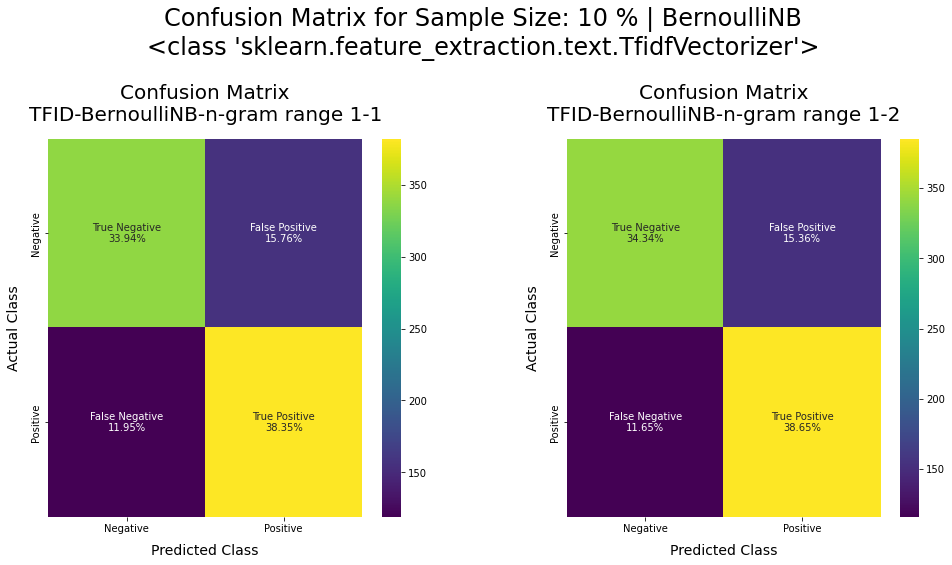

Beginning trials for MultinomialNB-<class 'sklearn.feature_extraction.text.TfidfVectorizer'>-2022-03-09 18:27:22.915610
Trial complete for MultinomialNB-<class 'sklearn.feature_extraction.text.TfidfVectorizer'>-ngram-1-1
Trial complete for MultinomialNB-<class 'sklearn.feature_extraction.text.TfidfVectorizer'>-ngram-1-2


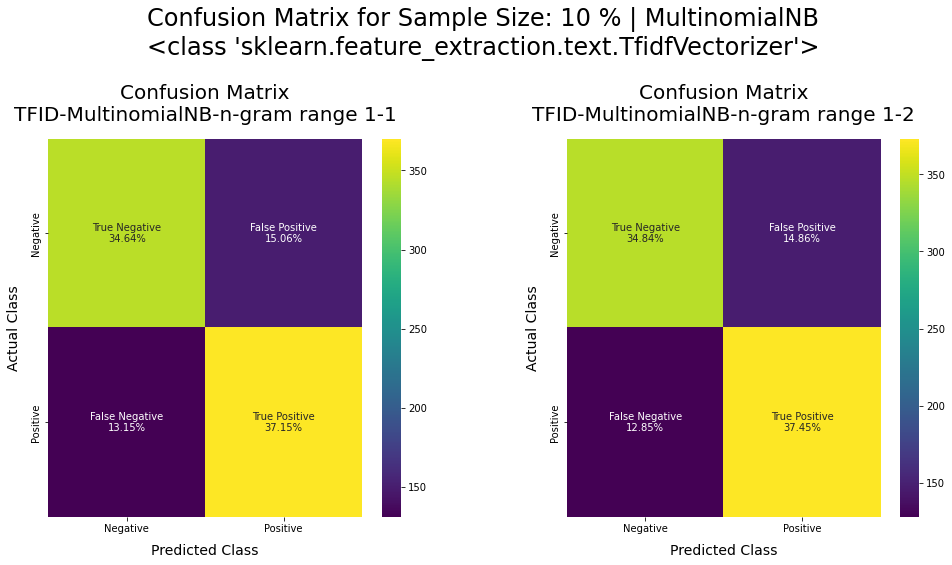

Beginning trials for BernoulliNB-<class 'sklearn.feature_extraction.text.CountVectorizer'>-2022-03-09 18:27:24.185410
Trial complete for BernoulliNB-<class 'sklearn.feature_extraction.text.CountVectorizer'>-ngram-1-1
Trial complete for BernoulliNB-<class 'sklearn.feature_extraction.text.CountVectorizer'>-ngram-1-2


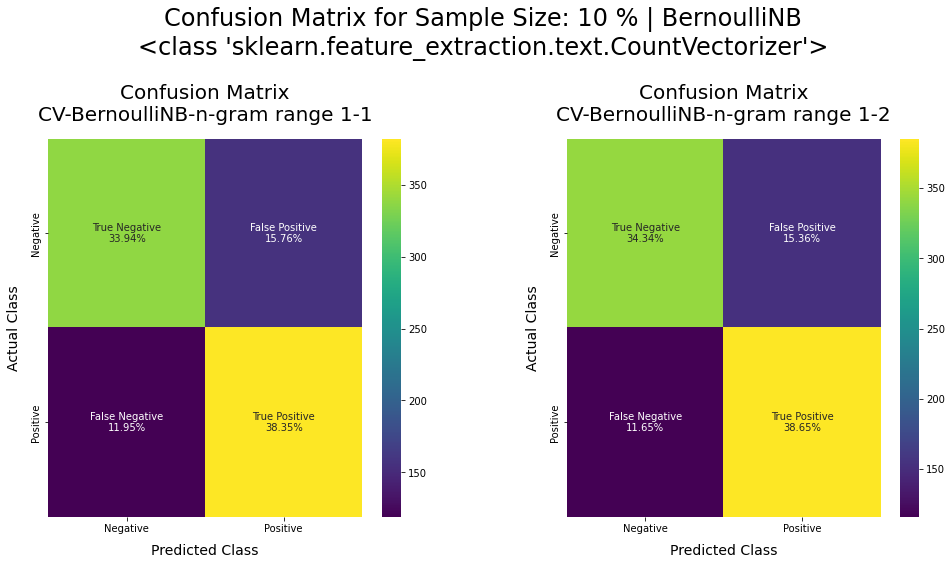

Beginning trials for MultinomialNB-<class 'sklearn.feature_extraction.text.CountVectorizer'>-2022-03-09 18:27:25.231912
Trial complete for MultinomialNB-<class 'sklearn.feature_extraction.text.CountVectorizer'>-ngram-1-1
Trial complete for MultinomialNB-<class 'sklearn.feature_extraction.text.CountVectorizer'>-ngram-1-2


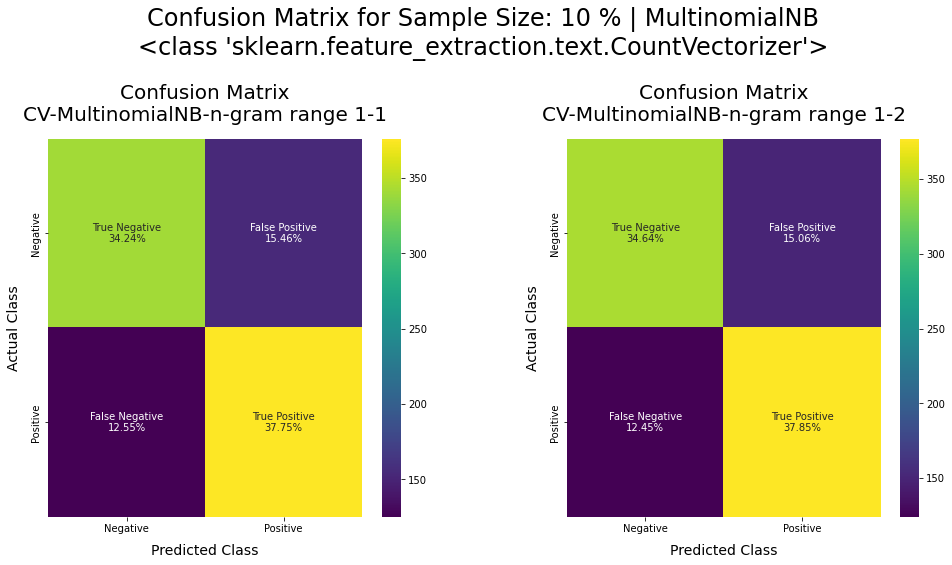

Beginning trials for BernoulliNB-<class 'sklearn.feature_extraction.text.TfidfVectorizer'>-2022-03-09 18:27:26.309048
Trial complete for BernoulliNB-<class 'sklearn.feature_extraction.text.TfidfVectorizer'>-ngram-1-1
Trial complete for BernoulliNB-<class 'sklearn.feature_extraction.text.TfidfVectorizer'>-ngram-1-2


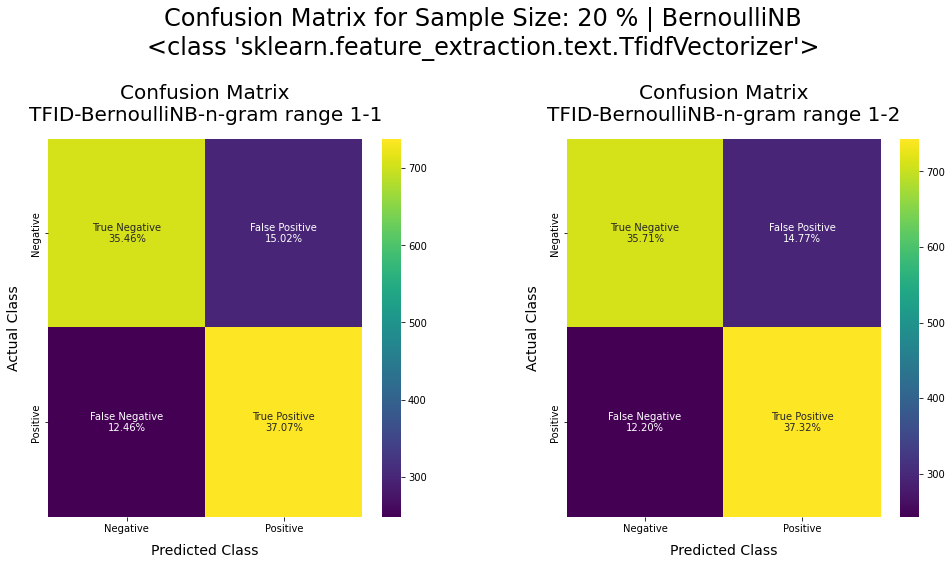

Beginning trials for MultinomialNB-<class 'sklearn.feature_extraction.text.TfidfVectorizer'>-2022-03-09 18:27:29.068843
Trial complete for MultinomialNB-<class 'sklearn.feature_extraction.text.TfidfVectorizer'>-ngram-1-1
Trial complete for MultinomialNB-<class 'sklearn.feature_extraction.text.TfidfVectorizer'>-ngram-1-2


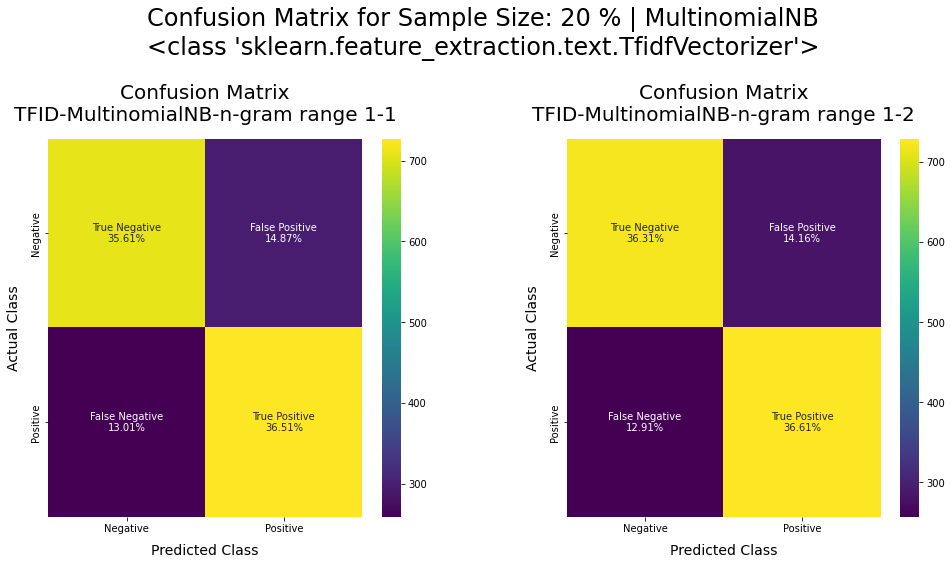

Beginning trials for BernoulliNB-<class 'sklearn.feature_extraction.text.CountVectorizer'>-2022-03-09 18:27:30.653146
Trial complete for BernoulliNB-<class 'sklearn.feature_extraction.text.CountVectorizer'>-ngram-1-1
Trial complete for BernoulliNB-<class 'sklearn.feature_extraction.text.CountVectorizer'>-ngram-1-2


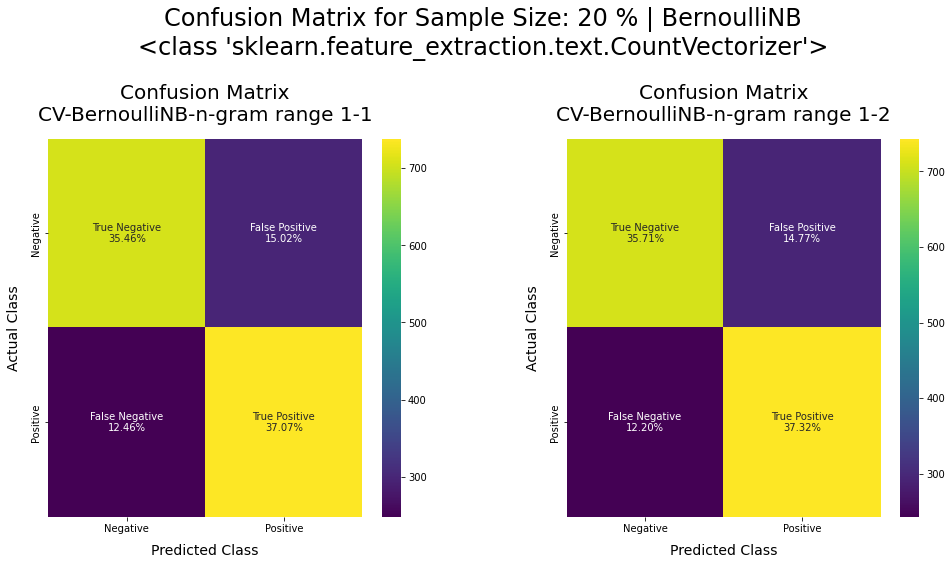

Beginning trials for MultinomialNB-<class 'sklearn.feature_extraction.text.CountVectorizer'>-2022-03-09 18:27:32.212253
Trial complete for MultinomialNB-<class 'sklearn.feature_extraction.text.CountVectorizer'>-ngram-1-1
Trial complete for MultinomialNB-<class 'sklearn.feature_extraction.text.CountVectorizer'>-ngram-1-2


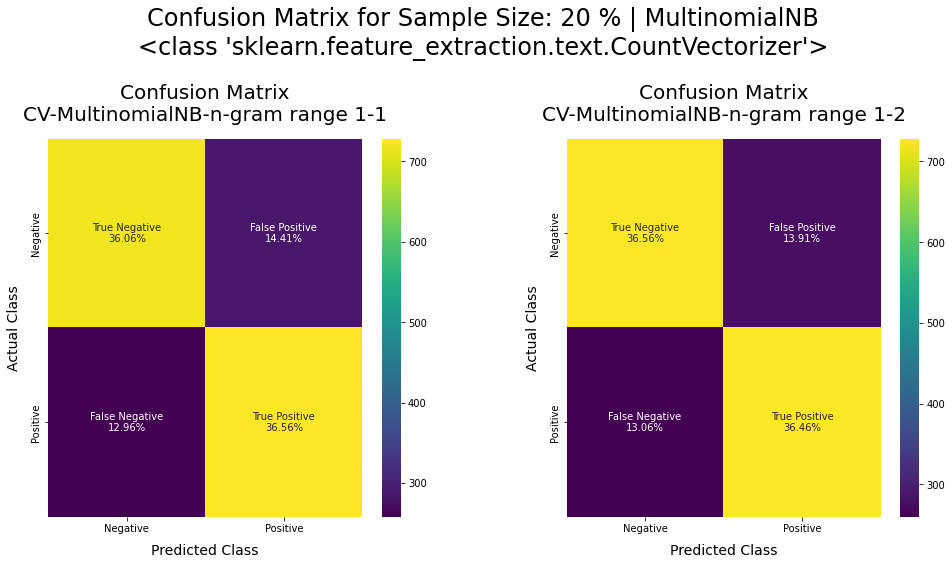

Beginning trials for BernoulliNB-<class 'sklearn.feature_extraction.text.TfidfVectorizer'>-2022-03-09 18:27:33.805469
Trial complete for BernoulliNB-<class 'sklearn.feature_extraction.text.TfidfVectorizer'>-ngram-1-1
Trial complete for BernoulliNB-<class 'sklearn.feature_extraction.text.TfidfVectorizer'>-ngram-1-2


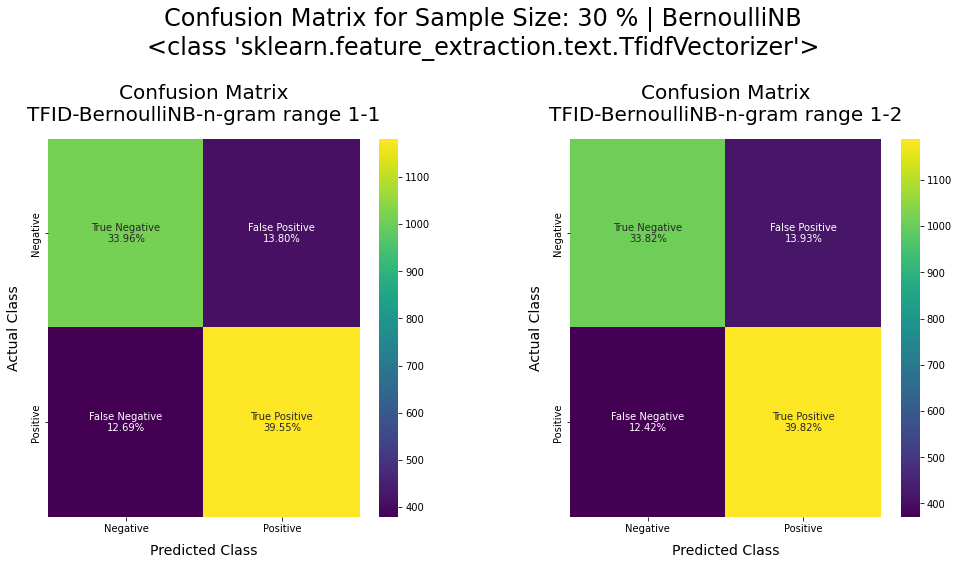

Beginning trials for MultinomialNB-<class 'sklearn.feature_extraction.text.TfidfVectorizer'>-2022-03-09 18:27:36.019071
Trial complete for MultinomialNB-<class 'sklearn.feature_extraction.text.TfidfVectorizer'>-ngram-1-1
Trial complete for MultinomialNB-<class 'sklearn.feature_extraction.text.TfidfVectorizer'>-ngram-1-2


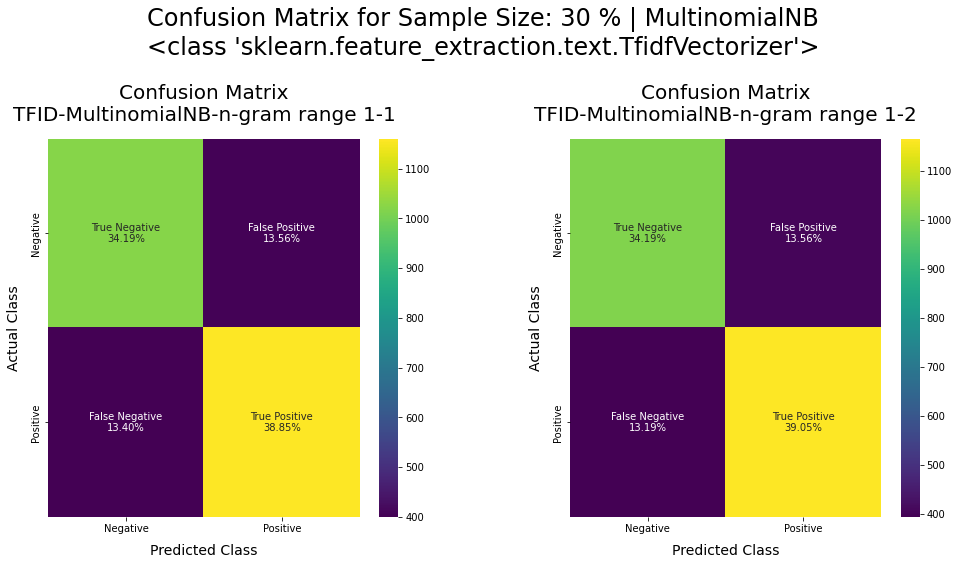

Beginning trials for BernoulliNB-<class 'sklearn.feature_extraction.text.CountVectorizer'>-2022-03-09 18:27:38.231657
Trial complete for BernoulliNB-<class 'sklearn.feature_extraction.text.CountVectorizer'>-ngram-1-1
Trial complete for BernoulliNB-<class 'sklearn.feature_extraction.text.CountVectorizer'>-ngram-1-2


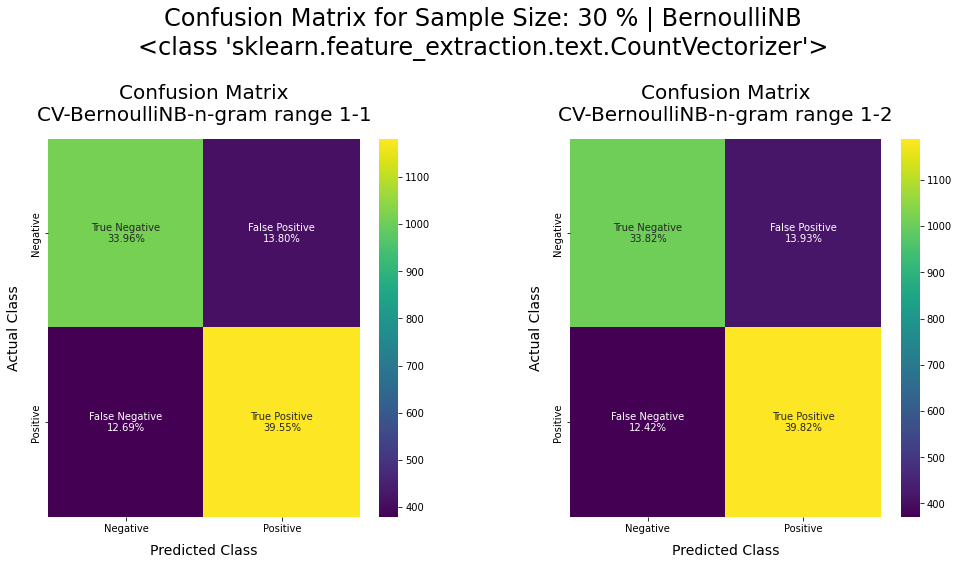

Beginning trials for MultinomialNB-<class 'sklearn.feature_extraction.text.CountVectorizer'>-2022-03-09 18:27:40.543237
Trial complete for MultinomialNB-<class 'sklearn.feature_extraction.text.CountVectorizer'>-ngram-1-1
Trial complete for MultinomialNB-<class 'sklearn.feature_extraction.text.CountVectorizer'>-ngram-1-2


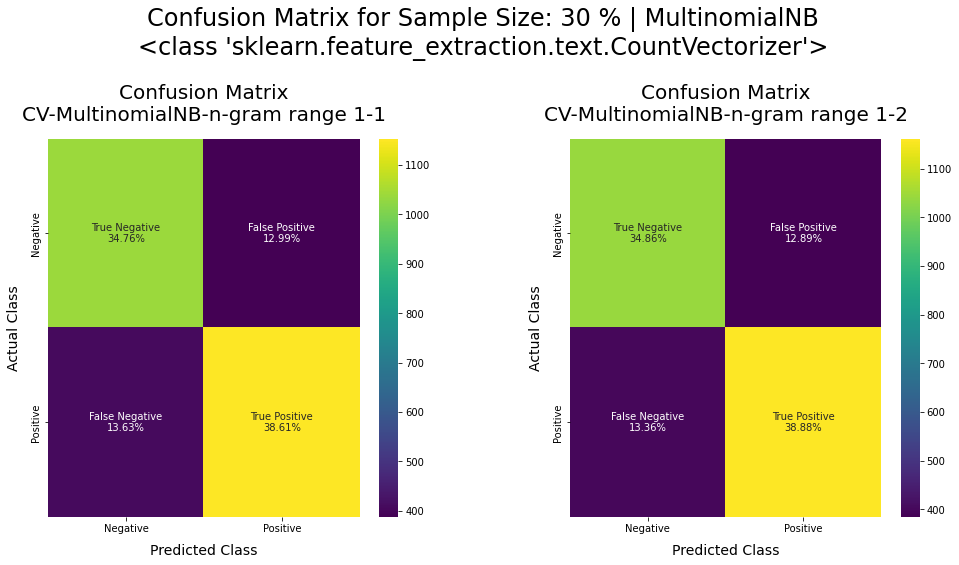

Beginning trials for BernoulliNB-<class 'sklearn.feature_extraction.text.TfidfVectorizer'>-2022-03-09 18:27:42.742332
Trial complete for BernoulliNB-<class 'sklearn.feature_extraction.text.TfidfVectorizer'>-ngram-1-1
Trial complete for BernoulliNB-<class 'sklearn.feature_extraction.text.TfidfVectorizer'>-ngram-1-2


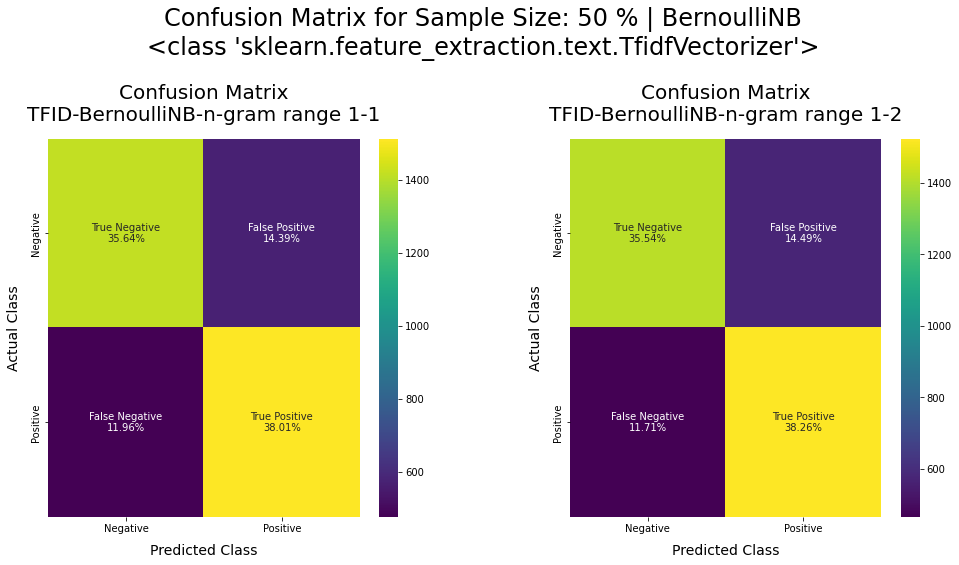

Beginning trials for MultinomialNB-<class 'sklearn.feature_extraction.text.TfidfVectorizer'>-2022-03-09 18:27:45.583702
Trial complete for MultinomialNB-<class 'sklearn.feature_extraction.text.TfidfVectorizer'>-ngram-1-1
Trial complete for MultinomialNB-<class 'sklearn.feature_extraction.text.TfidfVectorizer'>-ngram-1-2


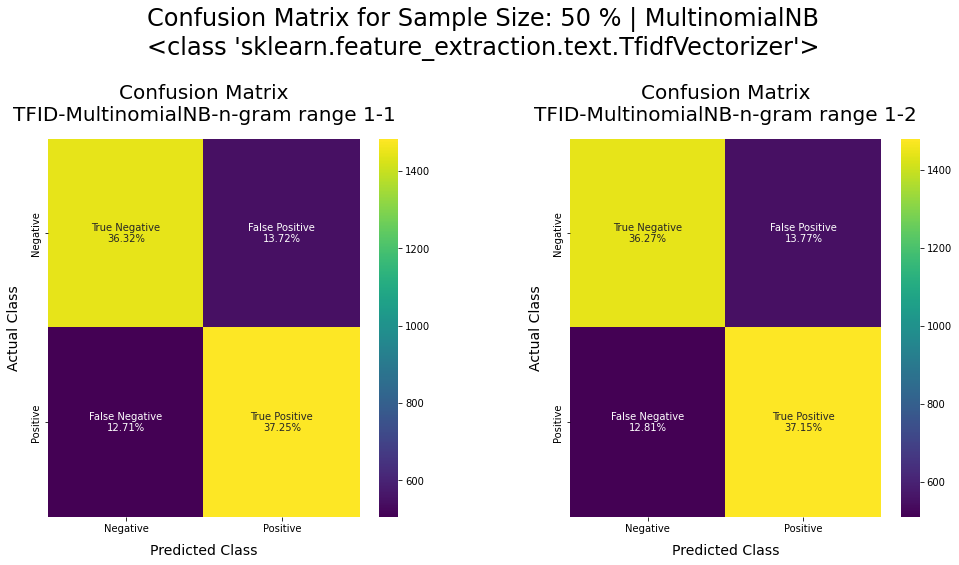

Beginning trials for BernoulliNB-<class 'sklearn.feature_extraction.text.CountVectorizer'>-2022-03-09 18:27:48.309523
Trial complete for BernoulliNB-<class 'sklearn.feature_extraction.text.CountVectorizer'>-ngram-1-1
Trial complete for BernoulliNB-<class 'sklearn.feature_extraction.text.CountVectorizer'>-ngram-1-2


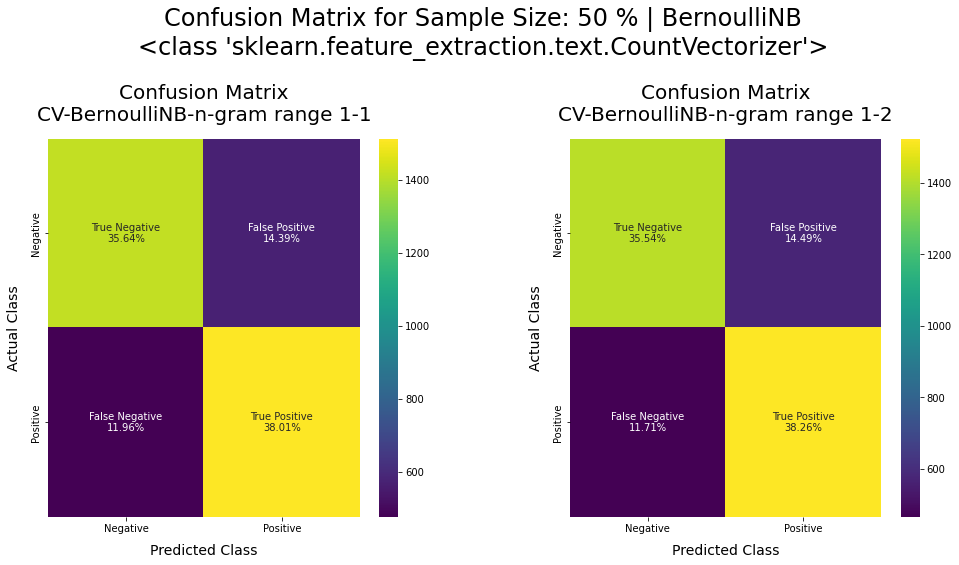

Beginning trials for MultinomialNB-<class 'sklearn.feature_extraction.text.CountVectorizer'>-2022-03-09 18:27:51.063533
Trial complete for MultinomialNB-<class 'sklearn.feature_extraction.text.CountVectorizer'>-ngram-1-1
Trial complete for MultinomialNB-<class 'sklearn.feature_extraction.text.CountVectorizer'>-ngram-1-2


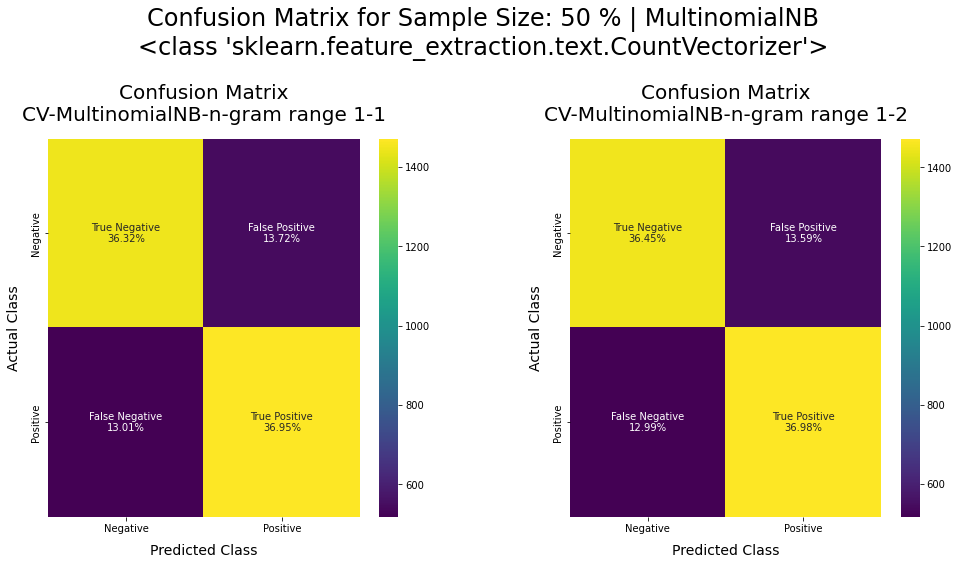

Beginning trials for BernoulliNB-<class 'sklearn.feature_extraction.text.TfidfVectorizer'>-2022-03-09 18:27:53.896146
Trial complete for BernoulliNB-<class 'sklearn.feature_extraction.text.TfidfVectorizer'>-ngram-1-1
Trial complete for BernoulliNB-<class 'sklearn.feature_extraction.text.TfidfVectorizer'>-ngram-1-2


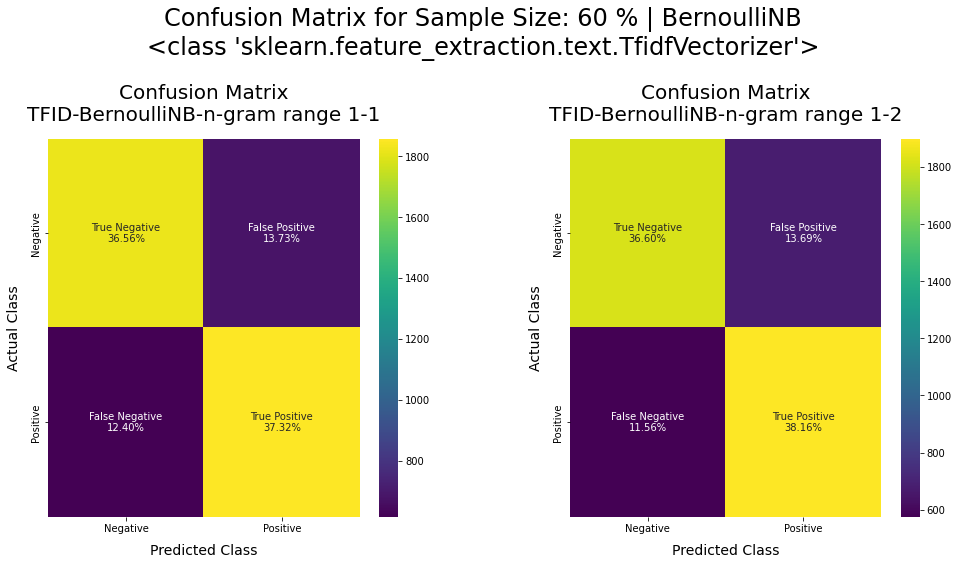

Beginning trials for MultinomialNB-<class 'sklearn.feature_extraction.text.TfidfVectorizer'>-2022-03-09 18:27:57.656969
Trial complete for MultinomialNB-<class 'sklearn.feature_extraction.text.TfidfVectorizer'>-ngram-1-1
Trial complete for MultinomialNB-<class 'sklearn.feature_extraction.text.TfidfVectorizer'>-ngram-1-2


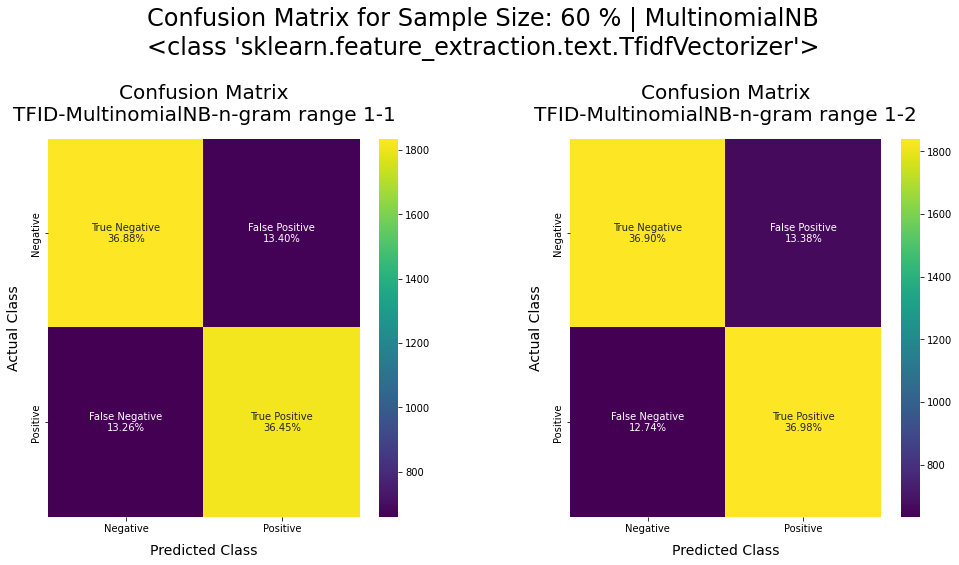

Beginning trials for BernoulliNB-<class 'sklearn.feature_extraction.text.CountVectorizer'>-2022-03-09 18:28:02.468083
Trial complete for BernoulliNB-<class 'sklearn.feature_extraction.text.CountVectorizer'>-ngram-1-1
Trial complete for BernoulliNB-<class 'sklearn.feature_extraction.text.CountVectorizer'>-ngram-1-2


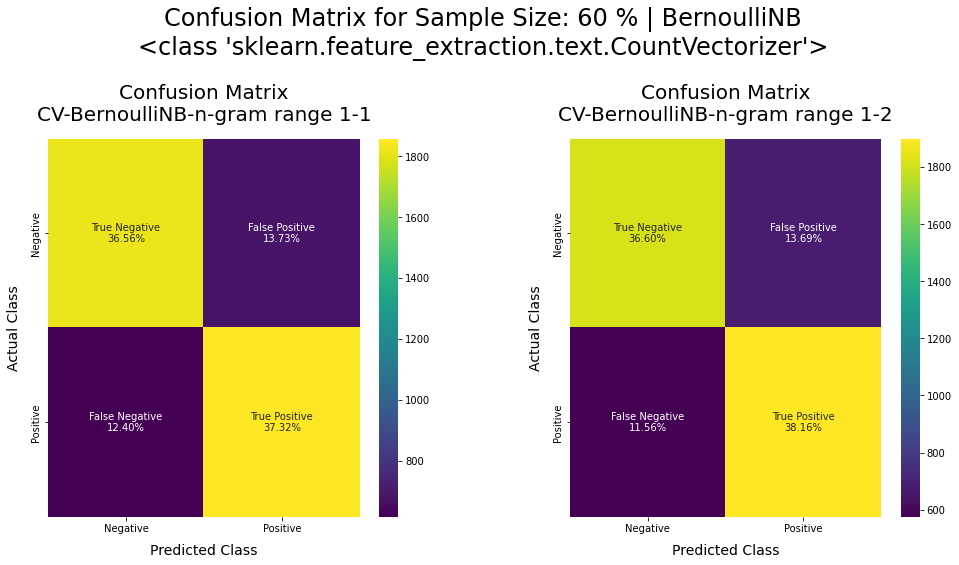

Beginning trials for MultinomialNB-<class 'sklearn.feature_extraction.text.CountVectorizer'>-2022-03-09 18:28:05.832034
Trial complete for MultinomialNB-<class 'sklearn.feature_extraction.text.CountVectorizer'>-ngram-1-1
Trial complete for MultinomialNB-<class 'sklearn.feature_extraction.text.CountVectorizer'>-ngram-1-2


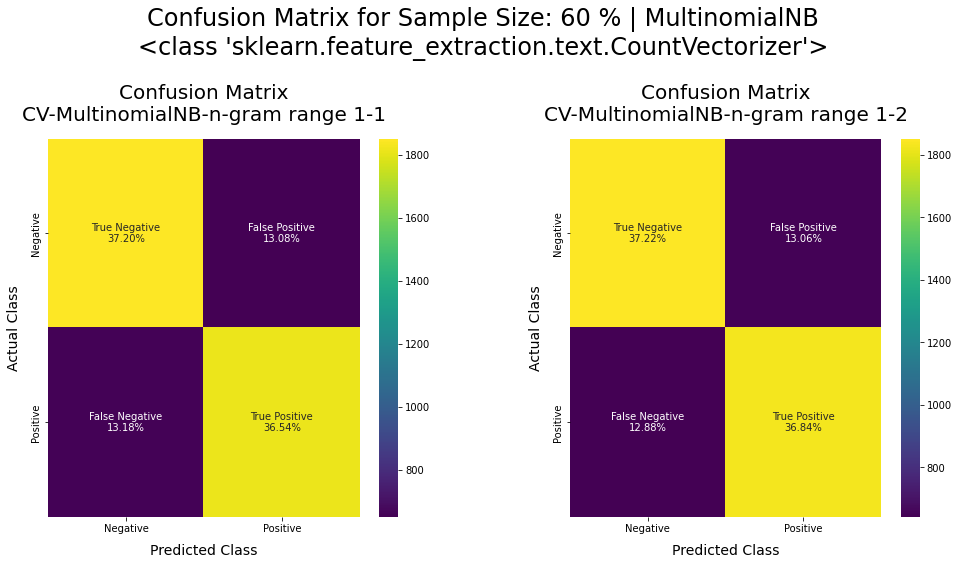

Beginning trials for BernoulliNB-<class 'sklearn.feature_extraction.text.TfidfVectorizer'>-2022-03-09 18:28:09.319726
Trial complete for BernoulliNB-<class 'sklearn.feature_extraction.text.TfidfVectorizer'>-ngram-1-1
Trial complete for BernoulliNB-<class 'sklearn.feature_extraction.text.TfidfVectorizer'>-ngram-1-2


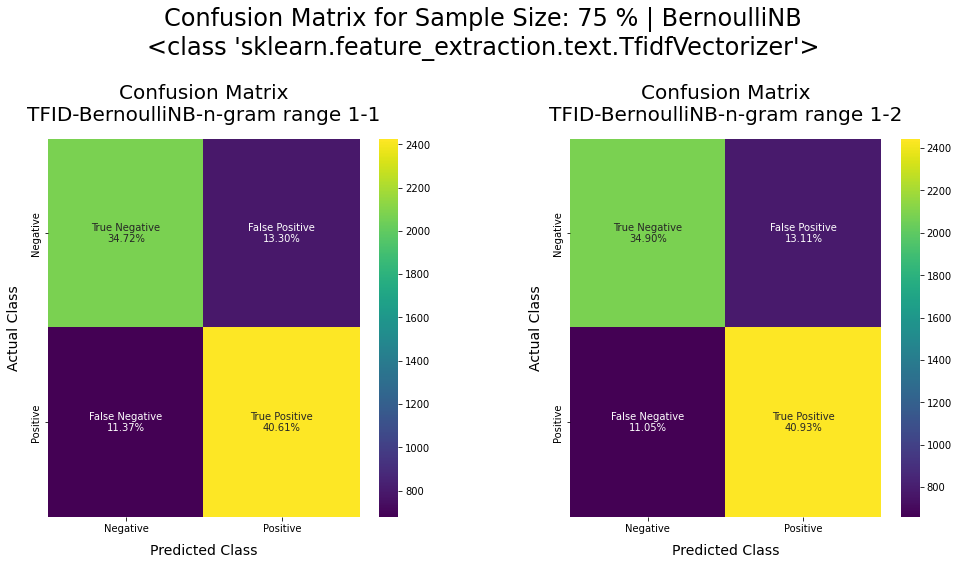

Beginning trials for MultinomialNB-<class 'sklearn.feature_extraction.text.TfidfVectorizer'>-2022-03-09 18:28:13.335816
Trial complete for MultinomialNB-<class 'sklearn.feature_extraction.text.TfidfVectorizer'>-ngram-1-1
Trial complete for MultinomialNB-<class 'sklearn.feature_extraction.text.TfidfVectorizer'>-ngram-1-2


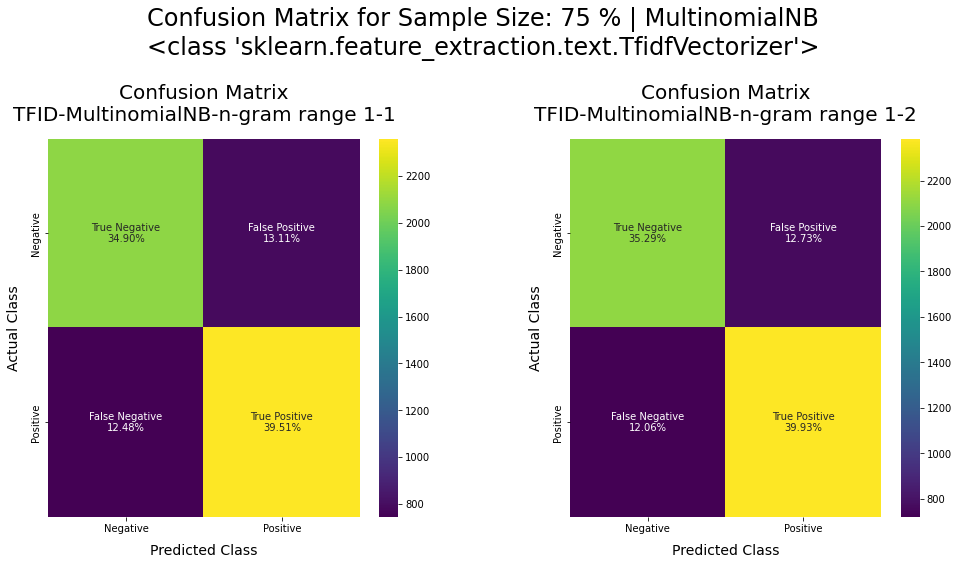

Beginning trials for BernoulliNB-<class 'sklearn.feature_extraction.text.CountVectorizer'>-2022-03-09 18:28:17.361407
Trial complete for BernoulliNB-<class 'sklearn.feature_extraction.text.CountVectorizer'>-ngram-1-1
Trial complete for BernoulliNB-<class 'sklearn.feature_extraction.text.CountVectorizer'>-ngram-1-2


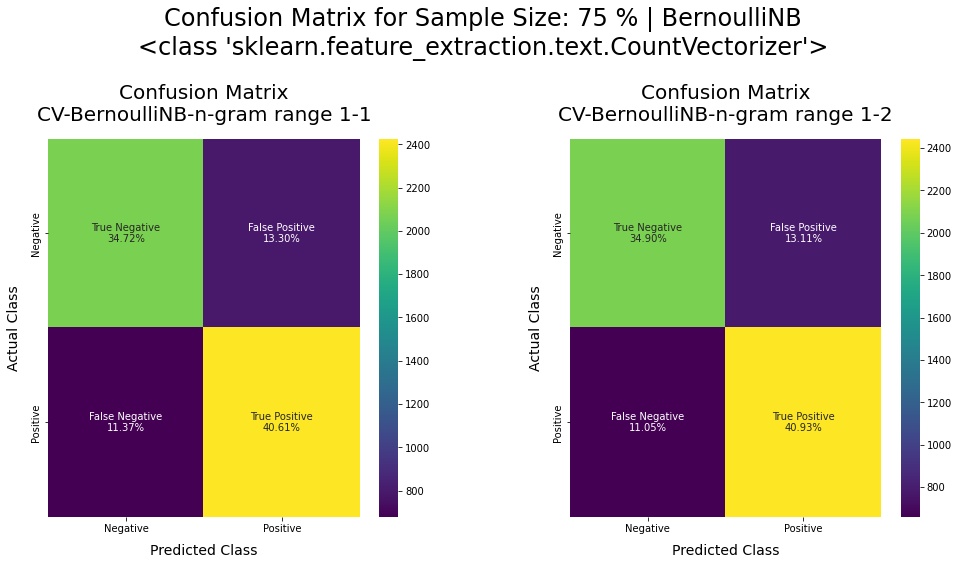

Beginning trials for MultinomialNB-<class 'sklearn.feature_extraction.text.CountVectorizer'>-2022-03-09 18:28:21.476027
Trial complete for MultinomialNB-<class 'sklearn.feature_extraction.text.CountVectorizer'>-ngram-1-1
Trial complete for MultinomialNB-<class 'sklearn.feature_extraction.text.CountVectorizer'>-ngram-1-2


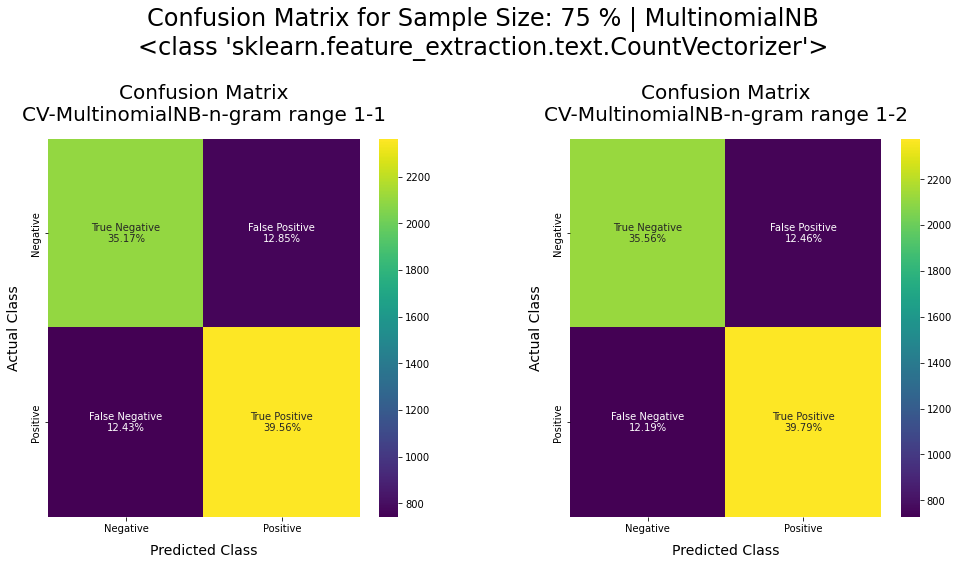

Beginning trials for BernoulliNB-<class 'sklearn.feature_extraction.text.TfidfVectorizer'>-2022-03-09 18:28:25.480923
Trial complete for BernoulliNB-<class 'sklearn.feature_extraction.text.TfidfVectorizer'>-ngram-1-1
Trial complete for BernoulliNB-<class 'sklearn.feature_extraction.text.TfidfVectorizer'>-ngram-1-2


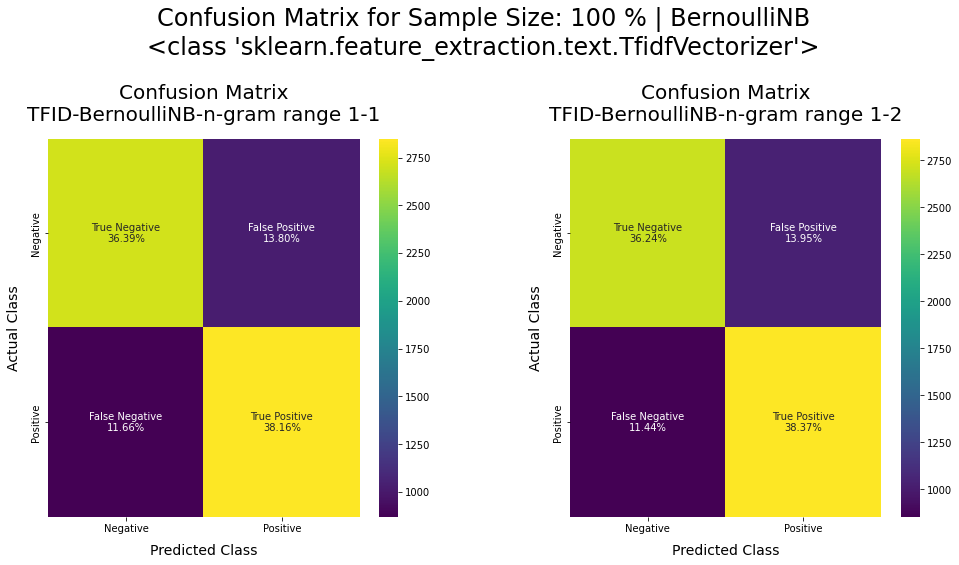

Beginning trials for MultinomialNB-<class 'sklearn.feature_extraction.text.TfidfVectorizer'>-2022-03-09 18:28:30.503016
Trial complete for MultinomialNB-<class 'sklearn.feature_extraction.text.TfidfVectorizer'>-ngram-1-1
Trial complete for MultinomialNB-<class 'sklearn.feature_extraction.text.TfidfVectorizer'>-ngram-1-2


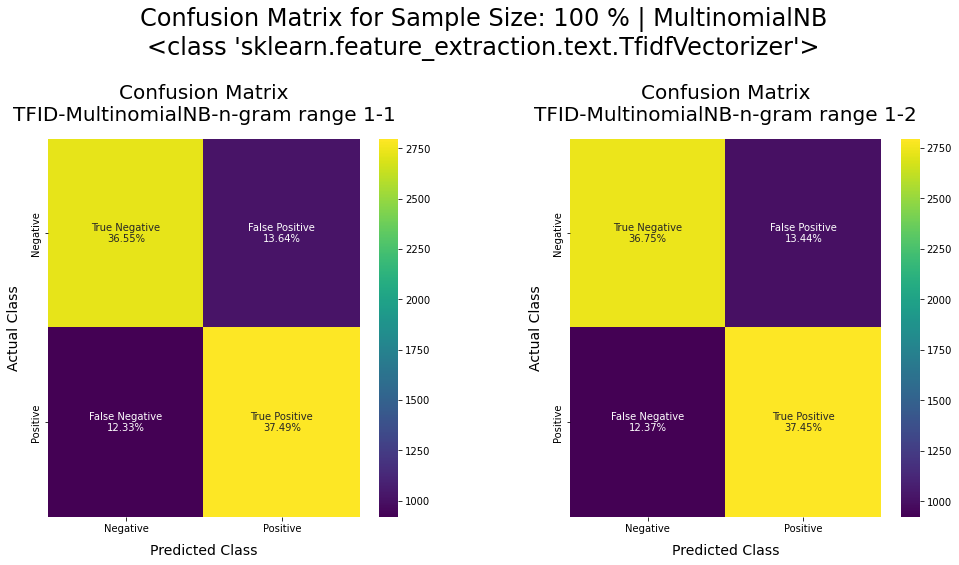

Beginning trials for BernoulliNB-<class 'sklearn.feature_extraction.text.CountVectorizer'>-2022-03-09 18:28:35.480042
Trial complete for BernoulliNB-<class 'sklearn.feature_extraction.text.CountVectorizer'>-ngram-1-1
Trial complete for BernoulliNB-<class 'sklearn.feature_extraction.text.CountVectorizer'>-ngram-1-2


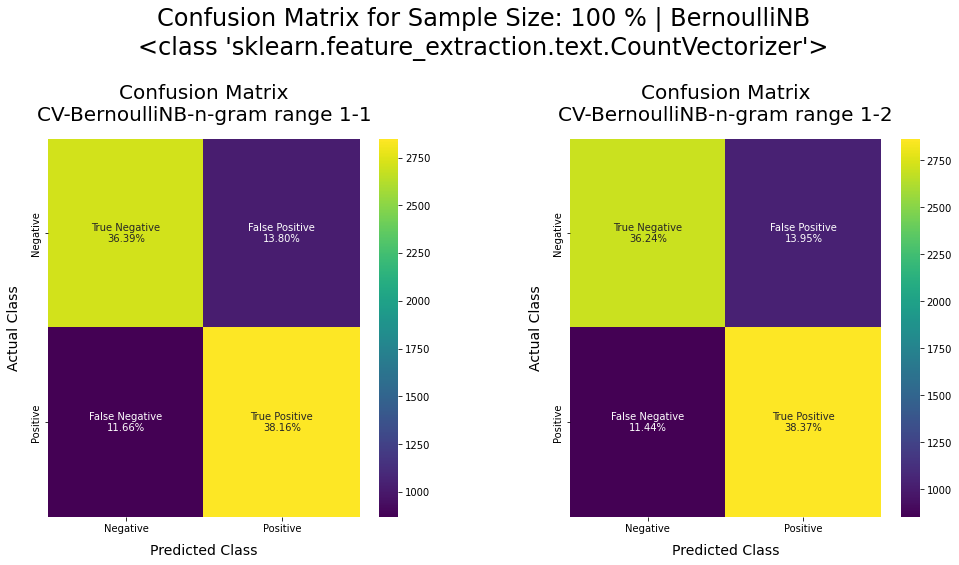

Beginning trials for MultinomialNB-<class 'sklearn.feature_extraction.text.CountVectorizer'>-2022-03-09 18:28:40.632107
Trial complete for MultinomialNB-<class 'sklearn.feature_extraction.text.CountVectorizer'>-ngram-1-1
Trial complete for MultinomialNB-<class 'sklearn.feature_extraction.text.CountVectorizer'>-ngram-1-2


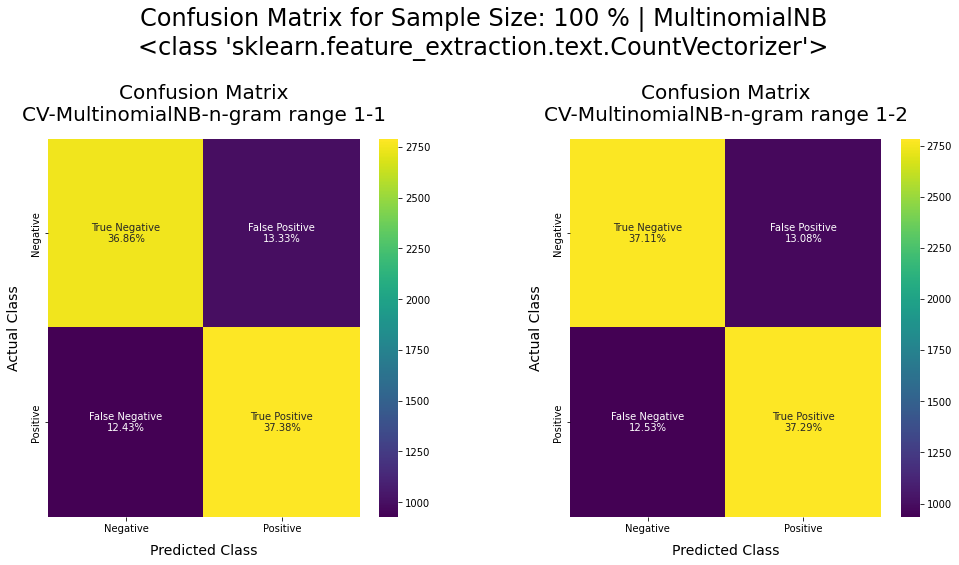

In [87]:
trial_logs = []
pred_list = []

clfs = [
    BernoulliNB(),
    MultinomialNB()
]
vectorizers = [TfidfVectorizer, CountVectorizer]

# The evaluation process iterates over all of our sample sizes
for sample_size, current_frame in sample_frames:
    y = current_frame.sentiment
    X = current_frame.drop(['sentiment'], axis=1)

    # Split the current frame into training and test data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10, random_state=42)
#     features = ['unigrams', 'bigrams', 'trigrams']

    for v_type, vectorizer in zip(["TFID", "CV"], vectorizers):
        for clf in clfs:
            print(f"Beginning trials for {type(clf).__name__}-{vectorizer}-{datetime.now()}")
            fig = plt.figure(figsize=(16, 16))
            rows, cols = 2, 2
            for i in range(2):
                X_train_feature = X_train['unigrams']
                X_test_feature = X_test['unigrams']

                # Vectorize the example text
                curr_vectorizer = vectorizer(ngram_range=(1,i+1), min_df=5, max_df=0.95, max_features=250000)
                curr_vectorizer.fit(X_train_feature)

                # Begin training the model with the vectorized input
                X_train_feature = curr_vectorizer.transform(X_train_feature)
                X_test_feature = curr_vectorizer.transform(X_test_feature)
                y_preds, f1, accuracy, report = evaluate_feature(clf, fig, (rows, cols, i + 1), X_train_feature,
                                                                 X_test_feature, y_train, y_test,
                                                                 f"{sample_size}-{type(clf).__name__}--{v_type}-ngram-{1}-{i+1}",
                                                                 labeling=f"{v_type}-{type(clf).__name__}-n-gram range {1}-{i+1}")
                precision = precision_score(y_test, y_preds)
                recall = recall_score(y_test, y_preds)

                # Save the current results to our trial log
                trial_logs.append({
                    "trial_name": f"{v_type}-ngram-{1}-{i+1}",
                    "vectorizer": f"{v_type}",
                    "classifier": f"{type(clf).__name__}",
                    "sample_size": float(sample_size) / 100,
                    "feature": f"ngram-{1}-{i+1}",
                    "accuracy": accuracy,
                    "f1_score": f1,
                    "precision": precision,
                    "recall": recall,
                    "report": report,
                    "feature_shape": len(curr_vectorizer.get_feature_names())
                })
                print(f"Trial complete for {type(clf).__name__}-{vectorizer}-ngram-{1}-{i+1}")
                pred_list.append((f"{clf}", accuracy, f1, y_preds))
            fig.tight_layout(pad=10.0)
            fig.suptitle(f"Confusion Matrix for Sample Size: {sample_size} % | {type(clf).__name__}\n{vectorizer}",  fontsize=24)
            plt.show()
            plt.close()

In [88]:
report_label = datetime.now().strftime("%m_%d_%Y_%H_%M_%S")
trial_logs.sort(key=lambda x: x['f1_score'], reverse=True)
trial_log_df = pd.DataFrame(trial_logs)
trial_log_df.head(10)

trial_name vectorizer     classifier  sample_size    feature  accuracy  \
0  TFID-ngram-1-2       TFID    BernoulliNB         0.75  ngram-1-2  0.758332   
1    CV-ngram-1-2         CV    BernoulliNB         0.75  ngram-1-2  0.758332   
2  TFID-ngram-1-1       TFID    BernoulliNB         0.75  ngram-1-1  0.753308   
3    CV-ngram-1-1         CV    BernoulliNB         0.75  ngram-1-1  0.753308   
4    CV-ngram-1-2         CV  MultinomialNB         0.75  ngram-1-2  0.753475   
5  TFID-ngram-1-2       TFID  MultinomialNB         0.75  ngram-1-2  0.752135   
6    CV-ngram-1-1         CV  MultinomialNB         0.75  ngram-1-1  0.747279   
7  TFID-ngram-1-1       TFID  MultinomialNB         0.75  ngram-1-1  0.744096   
8  TFID-ngram-1-2       TFID    BernoulliNB         0.60  ngram-1-2  0.747588   
9    CV-ngram-1-2         CV    BernoulliNB         0.60  ngram-1-2  0.747588   

   f1_score  precision    recall  \
0  0.772074   0.757360  0.787371   
1  0.772074   0.757360  0.787371   
2  0.767041   0.753340  0.781250   
3  0.767041   0.753340  0.781250   
4  0.763496   0.761538  0.765464   
5  0.763124   0.758270  0.768041   
6  0.757901   0.754874  0.760954   
7  0.755363   0.750796  0.759987   
8  0.751484   0.736047  0.767583   
9  0.751484   0.736047  0.767583   

                                              report  feature_shape  
0                precision    recall  f1-score   ...          10816  
1                precision    recall  f1-score   ...          10816  
2                precision    recall  f1-score   ...           6666  
3                precision    recall  f1-score   ...           6666  
4                precision    recall  f1-score   ...          10816  
5                precision    recall  f1-score   ...          10816  
6                precision    recall  f1-score   ...           6666  
7                precision    recall  f1-score   ...           6666  
8                precision    recall  f1-score   ...           9110  
9                precision    recall  f1-score   ...           9110

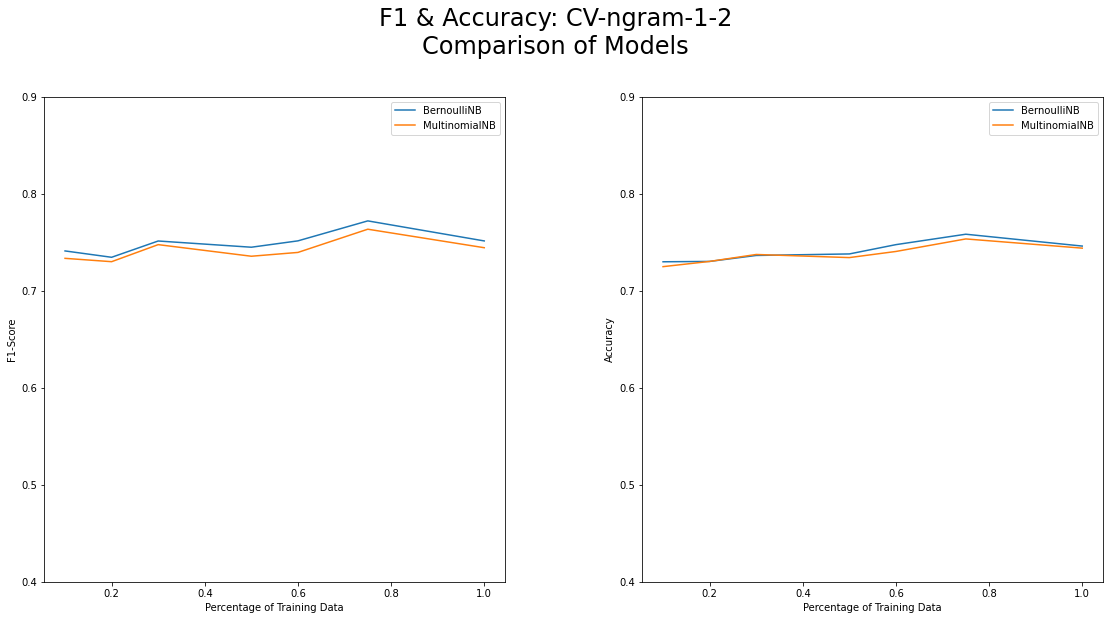

In [89]:

trial_log_df.sort_values(['classifier', 'sample_size'], inplace=True)
for name in sorted(['TFID-ngram-1-2', 'CV-ngram-1-2']):
    fig, axes = plt.subplots(1, 2, figsize=(18,10))
    for ax in axes.ravel():
        # ax.set_xscale('log')
        ax.set_ylim([0.60, 0.85])
        ax.set_yticks([0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

    # We are only concerned about the 1-2 n-gram range
    trial_mask = (trial_log_df['trial_name'] == name) & trial_log_df['feature'].str.contains('ngram-1-2')
    # Plot F1
    masked_df = trial_log_df[trial_mask].set_index('sample_size').groupby('classifier')
    masked_df["f1_score"].plot(legend=True, ax=axes[0], xlabel="Percentage of Training Data", ylabel="F1-Score")

    # fig.add_subplot(1, 2, 1)
    # Plot Accuracy on same figure
    masked_df = trial_log_df[trial_mask].set_index('sample_size').groupby('classifier')
    masked_df["accuracy"].plot(legend=True, ax=axes[1], xlabel="Percentage of Training Data", ylabel="Accuracy")
    # fig.add_subplot(1, 2, 2)

    # masked_df = trial_log_df[trial_mask].set_index('sample_size').groupby('classifier')
    fig.tight_layout(pad=10.0)
    fig.suptitle(f"F1 & Accuracy: {name}\nComparison of Models",  fontsize=24)
plt.close()